# Анализ лояльности пользователей и динамики продаж билетов на платформе Яндекс Афиша (июнь - октябрь 2024)

* Автор: Путилина Елизавета Евгеньевна
* Дата: 17.10.2025

**Введение**

Команда маркетинга платформы Яндекс Афиша поставила перед собой цель: расширить клиентскую базу платформы Яндекс Афиша и стимулировать пользователей к повторным покупкам. Период данных: 1 июня – 31 октября 2024 года.

**Цель проекта** -  провести исследовательский анализ данных EDA, чтобы выявить ключевые тренды и сформировать рекомендации для улучшения работы сервиса.

**Задачи проекта:**
* Загрузка и предобработка данных;
* Построить агрегированные признаки, описывающие поведение и профиль каждого пользователя;
* Исследование признаков, влияющих на возврат пользователей;
* Формирование выводов и рекомендаций для команды маркетинга.

**Содержимое проекта:**
1. [Загрузка данных и знакомство с ними](#chapter1)
2. [Предобработка данных](#chapter2)
3. [Создание профиля пользователя](#chapter3)
4. [Исследовательский анализ данных](#chapter4)
5. [Общий вывод и рекомендации](#chapter5)
6. [Финализация проекта и публикация в Git](#chapter6)

---

## 1. Загрузка данных и знакомство с ними <a class="anchor" id="chapter1"></a>


**Задача 1.1:** Напишем SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки будем использовать библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [209]:
# Установим необходимые библиотеки для подключения к базе данных
!pip install sqlalchemy
!pip install psycopg2-binary

In [210]:
# Установим необходимые библиотеки для обработки данных
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

In [211]:
# Для подключения к базе данных используем следующие параметры:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [212]:
# Внесем параметры в строку для соединения с базой данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [213]:
# Создаем соединение с базой даннных
engine = create_engine(connection_string)

In [214]:
# Пропишем запрос, выгружающий необходимую информацию из базы данных
query = '''
SELECT  user_id,
        device_type_canonical,
        order_id,
        created_dt_msk AS order_dt,
        created_ts_msk AS order_ts,
        currency_code,
        revenue,
        tickets_count,
        created_dt_msk::date - LAG(created_dt_msk::date) OVER(PARTITION BY user_id ORDER BY created_dt_msk)
AS days_since_prev,
        event_id,
        service_name,
        event_type_main,
        region_name,
        city_name        
FROM afisha.purchases AS p
JOIN afisha.events AS e USING(event_id)
JOIN afisha.city AS c ON e.city_id = c.city_id
JOIN afisha.regions AS re ON c.region_id = re.region_id
WHERE device_type_canonical IN ('mobile', 'desktop') AND event_type_main NOT IN ('фильм')
ORDER BY user_id;
''' 

In [215]:
# Запишем результат выдачи SQL-запроса в датафрейм
df = pd.read_sql_query(query, con=engine)

# Выводим строки датафрейма на экран
display(df)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,Весь в билетах,другое,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,Весь в билетах,другое,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,Прачечная,театр,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,Билеты без проблем,стендап,Широковская область,Ягодиновка


---

**Задача 1.2:** Изучим общую информацию о выгруженных данных.

In [216]:
# Выведем информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

**Промежуточный вывод**

Датасет `df` содержит 14 столбцов и 290611 строк, в которых представлена информация о клиентской базе платформы Яндекс Афиша. 

В ходе предварительной обработки данных (SQL) было выявлено, что пользователи чаще всего покупают билеты с мобильных устройств и 
стационарных компьютеров. Поэтому, другие устройства в ходе данного исследования не будут учитываться. Также, выручка `currency_code` представлена в российских рублях и казахстанских тенге, что необходимо учитывать при дальнейших расчётах.

Изучим типы данных и их корректность:

1. **Строковые данные (object).** В датасете представлено 7 столбцов с данными такого типа:
`user_id`, `device_type_canonical`, `currency_code`, `service_name`, `event_type_main`, `region_name`, `city_name` содержат строковую информацию. Тип данных `object` корректен;
2. **Числовые значения (int64).** В датасете представлены 3 столбца с данными такого типа:
`order_id`, `tickets_count`, `event_id`. Тип данных `int64` корректен;
3. **Числовые значения с плавающей запятой (float64).** В датасете представлено 2 столбца с данными такого типа:
* `revenue` - выручка от заказа. Тип данных `float64` корректен;
* `days_since_prev` - количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено. В данном столбце могут быть указаны неполные дни, поэтому тип `float64` здесь корректен. 
4. **Данные времени (datetime64).** В датасете представлено 2 столбца с данными такого типа:
* `order_dt` -  дата создания заказа;
* `order_ts` - время создания заказа.

Тип данных `datetime64` корректен.

В ходе анализа датасета `df` было выявлено, что в 1 из 14 столбцов (`days_since_prev`) есть пропуски. В данном столбце это означает, что пользователь совершил только одну покупку (оставим без изменений, чтобы избежать искажения данных).

Все типы данных представлены корректно.

---

##  2. Предобработка данных  <a class="anchor" id="chapter2"></a>

* Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведем выручку к единой валюте — российскому рублю.

Для этого, используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраним в новый столбец `revenue_rub`.

In [217]:
# Загрузка данных о курсе тенге к рублю в датафрейм
url = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'

exchange_rate_df = pd.read_csv(url)

# Выведем датафрейм `exchange_rate_df` на экран
display(exchange_rate_df)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


In [218]:
# Функция конвертации
def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return row['revenue'] / 100 * exchange_rate_df['curs'].values[0]
    else:
        return row['revenue']

In [219]:
# Конвертируем тенге в рубли и сохраним результаты в новый столбец `revenue_rub` датафрейма `df`
df['revenue_rub'] = df.apply(convert_to_rub, axis = 1)

In [220]:
# Проверяем разницу между валютами
print('Сравнение до и после конвертации:')
print(df[['currency_code', 'revenue', 'revenue_rub']].sort_values(by = ['currency_code'], ascending = True).head())

# Проверяем конвертацию для тенге
convert_to_tenge = df[df['currency_code'] == 'kzt']
print(f'\nКонвертировано {len(convert_to_tenge)} записей в тенге')

# Проверяем средний курс
if not convert_to_tenge.empty:
    avg_rate = (convert_to_tenge['revenue_rub'] / convert_to_tenge['revenue']).mean()
    print(f'\nСредний примененный курс: {avg_rate:.4f} руб за 1 тенге')

Сравнение до и после конвертации:
       currency_code   revenue  revenue_rub
83697            kzt  10338.19  2061.342042
175995           kzt   1849.41   368.755709
175997           kzt    414.43    82.633612
175998           kzt     82.19    16.387946
175999           kzt   1773.07   353.534200

Конвертировано 5069 записей в тенге

Средний примененный курс: 0.1994 руб за 1 тенге


* Проверим данные на пропущенные значения

In [221]:
# Посчитаем количество пропусков в каждом столбце в абсолютном значении
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [222]:
# Посчитаем количество пропусков в каждом столбце в относительном значении
round((df.isna().sum() / len(df)) * 100, 5)

user_id                  0.0000
device_type_canonical    0.0000
order_id                 0.0000
order_dt                 0.0000
order_ts                 0.0000
currency_code            0.0000
revenue                  0.0000
tickets_count            0.0000
days_since_prev          7.5472
event_id                 0.0000
service_name             0.0000
event_type_main          0.0000
region_name              0.0000
city_name                0.0000
revenue_rub              0.0000
dtype: float64

Пропуски есть только в столбце `days_since_prev` (7,6%). В данном столбце это означает, что пользователь совершил только одну покупку.

* Проверим уникальные значения в ключевых категориальных столбцах

In [223]:
# Анализ ключевых категориальных признаков
cat_columns_orders = ['device_type_canonical', 'currency_code', 'service_name', 'event_type_main', 'region_name', 'city_name']

for col in cat_columns_orders:
    print(f'Колонка: {col}')
    print(f'Уникальных значений: {df[col].nunique()}')
    print('Распределение значений:')
    print(f'{df[col].value_counts(normalize=True, dropna=False)}')
    print(f'Пропусков: {df[col].isna().sum()}\n')

Колонка: device_type_canonical
Уникальных значений: 2
Распределение значений:
mobile     0.800004
desktop    0.199996
Name: device_type_canonical, dtype: float64
Пропусков: 0

Колонка: currency_code
Уникальных значений: 2
Распределение значений:
rub    0.982557
kzt    0.017443
Name: currency_code, dtype: float64
Пропусков: 0

Колонка: service_name
Уникальных значений: 36
Распределение значений:
Билеты без проблем        0.218571
Лови билет!               0.141509
Билеты в руки             0.138821
Мой билет                 0.119882
Облачко                   0.091676
Лучшие билеты             0.061161
Весь в билетах            0.057978
Прачечная                 0.035350
Край билетов              0.021358
Тебе билет!               0.017990
Яблоко                    0.017339
Дом культуры              0.015491
За билетом!               0.009859
Городской дом культуры    0.009404
Show_ticket               0.007570
Мир касс                  0.007457
Быстробилет               0.006892
Выступл

* Проверим датафрейм `df` на наличие явных дубликатов.

In [224]:
# Вычислим количество явных дубликатов
df.duplicated(keep = 'last').sum()

0

Явные дубликаты отсутствуют.

* Проверим датафрейм `df` на наличие не явных дубликатов по ключевым полям.

In [225]:
# Вычислим количество неявных дубликатов
col_duplicates = ['user_id', 'event_id', 'order_dt', 'tickets_count']
all_duplicates = df[df.duplicated(subset = col_duplicates, keep = False)]

print(f'Неявные дубликаты: {len(all_duplicates)}')

# Удаление неявных дубликатов, оставляем последнюю запись в группе
cleaned_df = df.drop_duplicates(subset = col_duplicates, keep = 'last')

# Проверка после удаления
remaining_duplicates = cleaned_df[cleaned_df.duplicated(subset = col_duplicates, keep = False)]
print(f'Остались неявные дубликаты после очистки: {len(remaining_duplicates)}')
print(f'Количество записей после очистки: {len(cleaned_df)}')
print(f'Процент удаленных дубликатов: {1 - len(cleaned_df)/len(df):.2%}')

Неявные дубликаты: 86455
Остались неявные дубликаты после очистки: 0
Количество записей после очистки: 237334
Процент удаленных дубликатов: 18.33%


* Проверим распределение и наличие выбросов в столбцах `revenue_rub` и `tickets_count`.

In [226]:
# Выведем метрики для столбцов `revenue_rub`
print('Статистические показатели для столбца revenue_rub:')
cleaned_df['revenue_rub'].describe()

Статистические показатели для столбца revenue_rub:


count    237334.000000
mean        567.018323
std         894.315851
min         -90.760000
25%         124.380000
50%         370.370000
75%         815.247500
max       81174.540000
Name: revenue_rub, dtype: float64

По результатам анализа данных столбца `revenue_rub` было выявлено:
* присутствует большая разница между медианой (370) и средним значением (567), что говорит о неравномерном распределении данных;
* большой размах данных и высокое стандартное отклонение говорят о большом разбросе данных;
* большие значения min(-90.8) и max(81174,5) указывают на наличие выбросов.  

In [227]:
# Выведем метрики для столбцов `tickets_count`
print('Статистические показатели для столбца tickets_count:')
cleaned_df['tickets_count'].describe()

Статистические показатели для столбца tickets_count:


count    237334.000000
mean          2.755147
std           1.173599
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

По результатам анализа данных столбца `tickets_count` было выявлено:

* присутствует небольшая разница между медианой (3,0) и средним значением (2,8), что говорит об относительно нормальном распределении данных;
* большой размах данных и большое максимальное значение max(57) указывают на наличие выбросов.

Построим визуализации распределения значений для столбцов `revenue_rub` и `tickets_count`.

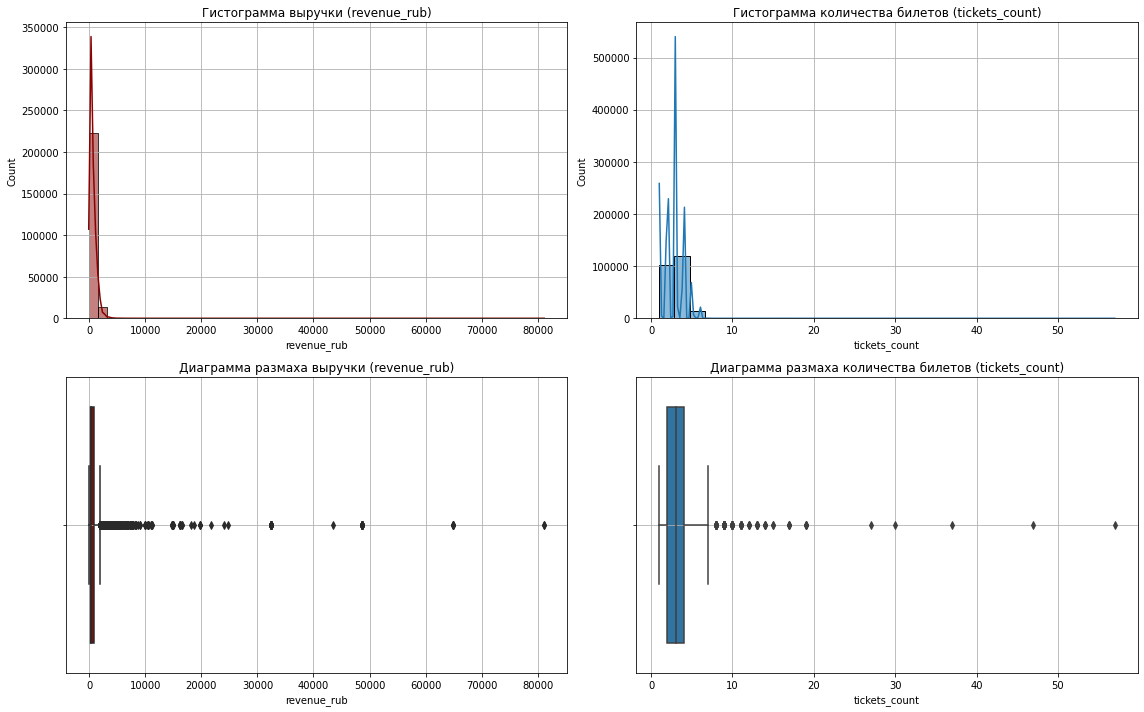

In [228]:
# Гистограммы и диаграммы размаха
fig, axes = plt.subplots(2, 2, figsize = (16, 10))

# Гистограмма для `revenue_rub`
sns.histplot(cleaned_df['revenue_rub'], bins = 50, kde = True, ax = axes[0, 0], color = 'darkred')
axes[0, 0].set_title('Гистограмма выручки (revenue_rub)')
axes[0, 0].grid()

# Диаграмма размаха для `revenue_rub`
sns.boxplot(data = cleaned_df, x = 'revenue_rub', ax = axes[1, 0], color = 'darkred')
axes[1, 0].set_title('Диаграмма размаха выручки (revenue_rub)')
axes[1, 0].grid()

# Гистограмма для `tickets_count`
sns.histplot(cleaned_df['tickets_count'], bins = 30, kde = True, ax = axes[0, 1])
axes[0, 1].set_title('Гистограмма количества билетов (tickets_count)')
axes[0, 1].grid()

# Диаграмма размаха для `tickets_count`
sns.boxplot(data = cleaned_df, x = 'tickets_count', ax = axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха количества билетов (tickets_count)')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

Из визуализации видно, что в столбцах `revenue_rub` и `tickets_count` пик распределения смещен в левую сторону. Также, присутствует длинный "хвост" с правой стороны, что говорит о выбросах. Отсекаем значения выше 99-го перцентиля.

In [229]:
# Пороговые значения по 99 перцентилю
revenue_rub_threshold = cleaned_df['revenue_rub'].quantile(0.99)
tickets_rub_threshold = cleaned_df['tickets_count'].quantile(0.99)

print('Пороговые значения (RUB):')
print(f'- Выручка: {revenue_rub_threshold:.2f}')
print(f'- Билеты: {tickets_rub_threshold}')

Пороговые значения (RUB):
- Выручка: 2594.44
- Билеты: 6.0


In [230]:
# Фильтруем выбросы
filtered_df = cleaned_df[(cleaned_df['revenue_rub'] <= revenue_rub_threshold) & (cleaned_df['tickets_count'] <= tickets_rub_threshold)]

In [231]:
# Проверяем размеры
print(f'Исходное количество записей: {len(df)}')
print(f'Очищенное количество записей: {len(filtered_df)}')
print(f'Процент удаленных записей: {1 - len(filtered_df)/len(df):.2%}')

Исходное количество записей: 290611
Очищенное количество записей: 234814
Процент удаленных записей: 19.20%


In [232]:
# Выведем метрики для столбцов `revenue_rub` после удаления выбросов
print('Статистические показатели для столбца revenue_rub:')
filtered_df['revenue_rub'].describe()

Статистические показатели для столбца revenue_rub:


count    234814.000000
mean        528.153751
std         508.122031
min         -90.760000
25%         122.320000
50%         364.280000
75%         800.000000
max        2594.440000
Name: revenue_rub, dtype: float64

In [233]:
# Выведем метрики для столбцов `tickets_count` после удаления выбросов
print('Статистические показатели для столбца tickets_count:')
filtered_df['tickets_count'].describe()

Статистические показатели для столбца tickets_count:


count    234814.000000
mean          2.736272
std           1.137820
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: tickets_count, dtype: float64

Построим визуализации распределения значений для столбцов `revenue_rub` и `tickets_count` после очистки от выбросов.

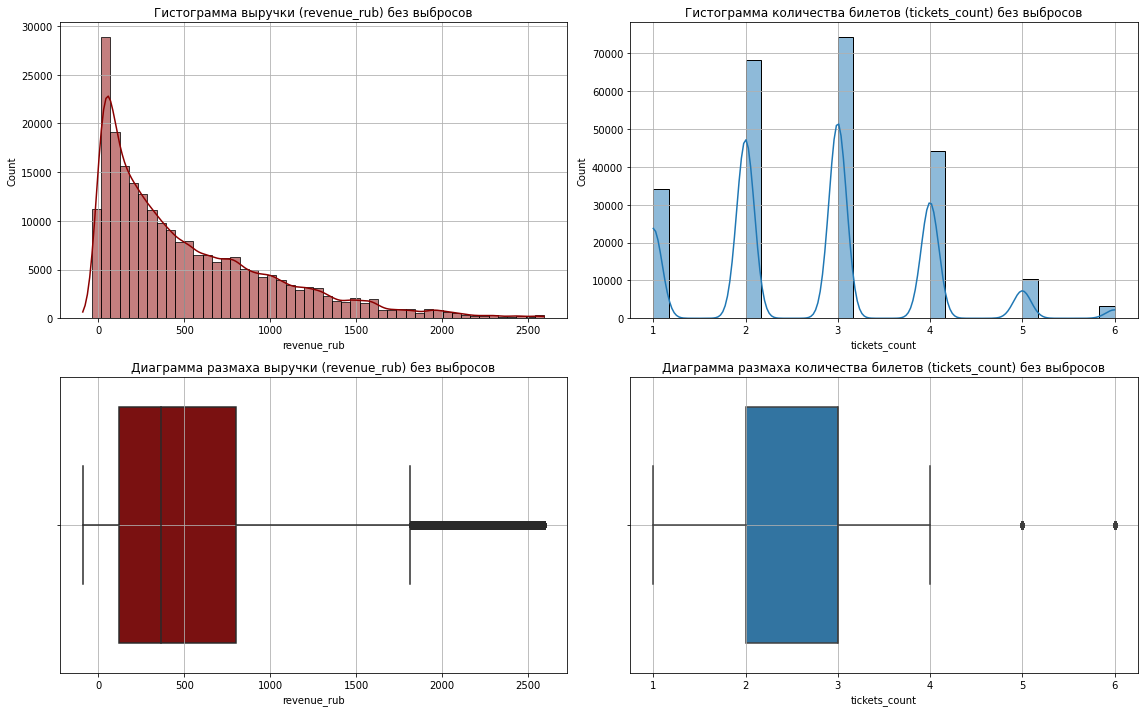

In [234]:
# Гистограммы и диаграммы размаха
fig, axes = plt.subplots(2, 2, figsize = (16, 10))

# Гистограмма для `revenue_rub` без выбросов
sns.histplot(filtered_df['revenue_rub'], bins = 50, kde = True, ax = axes[0, 0], color = 'darkred')
axes[0, 0].set_title('Гистограмма выручки (revenue_rub) без выбросов')
axes[0, 0].grid()

# Диаграмма размаха для `revenue_rub` без выбросов
sns.boxplot(data = filtered_df, x = 'revenue_rub', ax = axes[1, 0], color = 'darkred')
axes[1, 0].set_title('Диаграмма размаха выручки (revenue_rub) без выбросов')
axes[1, 0].grid()

# Гистограмма для `tickets_count` без выбросов
sns.histplot(filtered_df['tickets_count'], bins = 30, kde = True, ax = axes[0, 1])
axes[0, 1].set_title('Гистограмма количества билетов (tickets_count) без выбросов')
axes[0, 1].grid()

# Диаграмма размаха для `tickets_count` без выбросов
sns.boxplot(data = filtered_df, x = 'tickets_count', ax = axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха количества билетов (tickets_count) без выбросов')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

* Проверим столбец `revenue` на наличие аномалий.

In [235]:
# Проверим, имеет ли столбец `revenue` отрицательные значения
negative_count = (filtered_df['revenue'] < 0).sum()
print(f'Количество отрицательных значений: {negative_count}')

Количество отрицательных значений: 325


После удаления выбросов в столбце `revenue` видно, что выручка имеет большой разброс. Это может быть связано со спросом и популярностью различных мероприятий. Также, в данном столбце имеются отрицательные значения (количество: 325). Можно предложить гипотезу, что отрицательные значения - это возврат средств.

В столбце `tickets_count` видно, что в среднем, пользователи преобретают 2-3 билета на различные мероприятия. Минимальное количество пользователей платформы Яндекс Афиша преобретают 5-6 билетов.

**Промежуточный вывод**

Для оптимизации работы с данными в датафрейме была выполнена предобработка данных:

* Данные о выручке сервиса были приведены к единой валюте — российскому рублю. Добавлен столбец `revenue_rub`;
* Пропуски имеются только в столбце `days_since_prev` (7,6%). В данном столбце это означает, что пользователь совершил только одну покупку;
* Данные проверены на наличие явных и неявных дубликатов. Явные дубликаты отсутствуют. Обнаружены не явные дубликаты по лючевым столбцам (18.33% от общего числа данных) и удалены. Датафрейм после удаления неявных дубликатов содержит 237334 строк;
* Столбцы `revenue` и `tickets_count` были проверены на наличие выбросов. Данные выше 99-го перцентиля были удалены.

Финальный датафрейм содержит 234814 строк из 290611 исходных.

После удаления выбросов в столбце `revenue` данные имеют большой разброс и неравномерное распределение. Можно предложить гипотезу, что это может быть связано со спросом и популярностью различных мероприятий. Для выявления причины такого разброса необходимо проанализировать пользователей платформы и их предпочтения. Также, в данном столбце имеются отрицательные значения (количество: 325). Можно предложить гипотезу, что отрицательные значения - это возврат средств.

В столбце `tickets_count`, после удаления, выбросов данные имеют относительно нормальное распределение и небольшой разброс. В среднем, пользователи преобретают 2-3 билета на различные мероприятия. Это достаточно низкие показатели. Минимальное количество пользователей платформы Яндекс Афиша преобретают 5-6 билетов.

---

## 3. Создание профиля пользователя <a class="anchor" id="chapter3"></a>

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас необходимо построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Построим профиль пользователя — для каждого пользователя найдём:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавим два бинарных признака:

- `is_two` — совершил ли пользователь больше двух заказов;
- `is_five` — совершил ли пользователь больше пяти заказов.


* Перед тем как строить профиль, отсортируем данные по времени совершения заказа.

In [236]:
# Отсортируем данные по времени совершения заказа
filtered_df = filtered_df.sort_values(by = ['order_ts'], ascending = True)

# Выведем датафрейм
display(filtered_df)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
285281,fd4d47438ebb946,mobile,7565637,2024-06-01,2024-06-01 00:00:42,rub,1083.15,4,0.0,131671,Прачечная,театр,Каменевский регион,Глиногорск,1083.15
285282,fd4d47438ebb946,mobile,7565521,2024-06-01,2024-06-01 00:01:30,rub,812.36,3,0.0,131671,Прачечная,театр,Каменевский регион,Глиногорск,812.36
118843,57ef0a1905ac488,mobile,6670842,2024-06-01,2024-06-01 00:01:58,rub,2091.31,4,NaN,375861,Билеты в руки,театр,Лесодальний край,Родниковец,2091.31
264550,e73089d7d016cd8,mobile,5502055,2024-06-01,2024-06-01 00:03:34,rub,181.39,2,0.0,211846,Прачечная,театр,Широковская область,Радужнополье,181.39
37413,18e9aead0a393e7,mobile,5948307,2024-06-01,2024-06-01 00:04:54,rub,1030.49,3,NaN,514904,Облачко,концерты,Каменевский регион,Глиногорск,1030.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53076,1f5005b3af584c9,mobile,5164437,2024-10-31,2024-10-31 23:57:10,rub,533.33,2,0.0,487517,Облачко,концерты,Озернинский край,Родниковецк,533.33
186718,992f64b9657ff00,mobile,5935170,2024-10-31,2024-10-31 23:57:51,rub,1209.21,4,1.0,585076,Весь в билетах,ёлки,Каменевский регион,Глиногорск,1209.21
156324,7eb4fc207ecc10f,mobile,7928369,2024-10-31,2024-10-31 23:58:55,rub,1954.78,5,0.0,420149,Облачко,концерты,Каменевский регион,Глиногорск,1954.78
70012,3127060e4f02037,mobile,1307582,2024-10-31,2024-10-31 23:59:51,rub,385.81,2,0.0,589958,Мой билет,концерты,Североярская область,Озёрск,385.81


* Создадим профиль пользователя

In [237]:
user_profile = filtered_df.groupby(['user_id']).agg(
    min_order_dt = ('order_dt', 'min'),  # дата первого заказа
    max_order_dt = ('order_dt', 'max'),  # дата последнего заказа
    device_type_canonical = ('device_type_canonical', lambda x: x.iloc[0]),  # устройство, с которого был сделан первый заказ
    region_name = ('region_name', lambda x: x.iloc[0]),  # регион, в котором был сделан первый заказ
    service_name = ('service_name', lambda x: x.iloc[0]),  # билетного партнёра, к которому обращались при первом заказе
    event_type_main = ('event_type_main', lambda x: x.iloc[0]),  # жанр первого посещённого мероприятия
    total_orders = ('order_id', 'count'),  # общее количество заказов
    avg_revenue_rub = ('revenue_rub', 'mean'),  # средняя выручка с одного заказа в рублях
    avg_tickets_count = ('tickets_count', 'mean')  # среднее количество билетов в заказе
)

# Вычисляем разницу во времени между заказами для каждого пользователя
filtered_df['time_diff'] = filtered_df.groupby('user_id')['order_ts'].diff().dt.total_seconds() / (60 * 60 * 24)  # разница в днях

# Рассчитываем среднее время между заказами для каждого пользователя
user_profile['average_time_between_orders'] = round(filtered_df.groupby('user_id')['time_diff'].mean().astype(float), 2)

# Заполним значениями-индексами пропуски в столбце `average_time_between_orders`
user_profile = user_profile.fillna({'average_time_between_orders':0})

# Подсчитываем общее количество заказов для каждого пользователя
orders_for_users = filtered_df.groupby('user_id')['order_id'].count().reset_index(name = 'total_orders')

# Определяем функцию для вычисления бинарных признаков
def set_binary_flags(row):
    row['is_two'] = row['total_orders'] > 2
    row['is_five'] = row['total_orders'] > 5
    return row

# Применяем функцию к каждой строке DataFrame
orders_for_users = orders_for_users.apply(set_binary_flags, axis=1)

# Объединяем с профилем пользователя
user_profile = user_profile.merge(orders_for_users[['user_id', 'is_two', 'is_five']], on='user_id', how='left')

display(user_profile)

,user_id,min_order_dt,max_order_dt,device_type_canonical,region_name,service_name,event_type_main,total_orders,avg_revenue_rub,avg_tickets_count,average_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,0.00,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,74.81,False,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,50.91,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,0.00,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,15.62,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21825,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,7,621.661429,2.714286,17.81,True,True
21826,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,850.995000,2.500000,74.38,False,False
21827,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,Каменевский регион,Билеты без проблем,концерты,25,589.893600,2.680000,5.49,True,True
21828,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,661.530000,2.000000,0.00,False,False


Всего в датафрейме 21830 уникальных пользователя.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитаем:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших более 2 и более 5 заказов.

Также изучим статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оценим данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [238]:
# Общее число пользователей в выборке
nunique_users = user_profile['user_id'].nunique()

# Средняя выручка с одного заказа
average_revenue_per_order = round(user_profile['avg_revenue_rub'].mean(), 3)

# Доля пользователей, совершивших более 2 заказов
share_more_than_two = round(user_profile['is_two'].mean() * 100, 2)

# Доля пользователей, совершивших более 5 заказов
share_more_than_five = round(user_profile['is_five'].mean() * 100, 2)

# общее число заказов
count_orders = user_profile['total_orders'].nunique()

# Среднее число билетов в заказе
average_tickets_per_order = round(user_profile.groupby('user_id')['avg_tickets_count'].mean().mean(), 2)

# Среднее количество дней между покупками
overall_average_days = round(user_profile.groupby('user_id')['average_time_between_orders'].mean().mean(), 2)

print(f'Общее число пользователей: {total_users}')
print(f'Средняя выручка с одного заказа: {average_revenue_per_order}')
print(f'Доля пользователей, совершивших более 2 заказов: {share_more_than_two}%')
print(f'Доля пользователей, совершивших более 5 заказов: {share_more_than_five}%')
print(f'Среднее общее заказов: {count_orders}')
print(f'Среднее число билетов в заказе: {average_tickets_per_order}')
print(f'Среднее количество дней между покупками: {overall_average_days}')

Общее число пользователей: 19856
Средняя выручка с одного заказа: 541.827
Доля пользователей, совершивших более 2 заказов: 41.2%
Доля пользователей, совершивших более 5 заказов: 20.66%
Среднее общее заказов: 296
Среднее число билетов в заказе: 2.74
Среднее количество дней между покупками: 10.84


Проверим распределение и наличие выбросов в столбцах `total_orders` и `avg_tickets_count`.

In [239]:
# Выведем метрики для столбцов `total_orders`
print('Статистические показатели для столбца total_orders:')
user_profile['total_orders'].describe()

Статистические показатели для столбца total_orders:


count    21830.000000
mean        10.756482
std        100.348992
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       8569.000000
Name: total_orders, dtype: float64

По результатам анализа данных столбца `total_orders` было выявлено:

* присутствует большая разница между медианой (2) и средним значением (10,75), что говорит о неравномерном распределении данных;
* большой размах данных и высокое стандартное отклонение (100,34) говорят о большом разбросе данных;
* большое максимальное значение max (8569) указывает на наличие выбросов.

In [240]:
# Выведем метрики для столбцов `avg_tickets_count`
print('Статистические показатели для столбца avg_tickets_count:')
user_profile['avg_tickets_count'].describe()

Статистические показатели для столбца avg_tickets_count:


count    21830.000000
mean         2.737965
std          0.896790
min          1.000000
25%          2.000000
50%          2.750000
75%          3.000000
max          6.000000
Name: avg_tickets_count, dtype: float64

По результатам анализа данных столбца `avg_tickets_count` было выявлено:

* почти одинаковые значения медианы (2,75) и среднего значения (2,73), что говорит о нормальном распределении данных;
* небольшой размах данных и небольшое максимальное значение max(6) указывают на наличие правого хвоста.

Построим визуализации распределения значений для столбцов `total_orders` и `avg_tickets_count`.

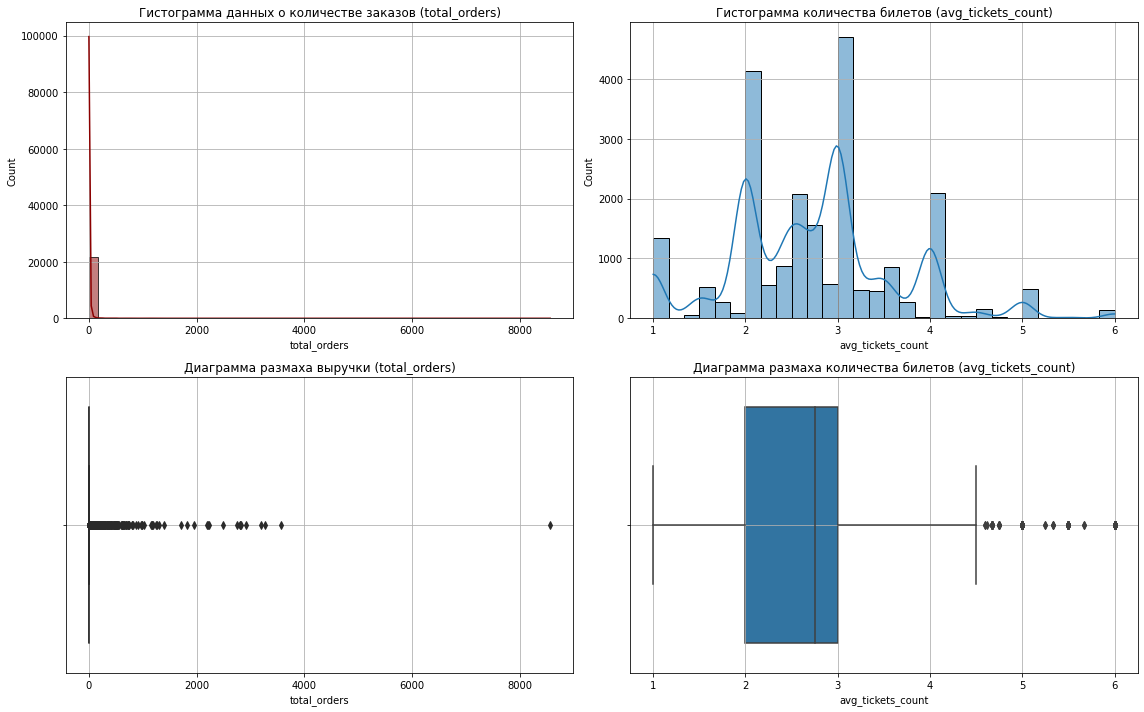

In [241]:
# Гистограммы и диаграммы размаха
fig, axes = plt.subplots(2, 2, figsize = (16, 10))

# Гистограмма для `total_orders`
sns.histplot(user_profile['total_orders'], bins = 50, kde = True, ax = axes[0, 0], color = 'darkred')
axes[0, 0].set_title('Гистограмма данных о количестве заказов (total_orders)')
axes[0, 0].grid()

# Диаграмма размаха для `total_orders`
sns.boxplot(data = user_profile, x = 'total_orders', ax = axes[1, 0], color = 'darkred')
axes[1, 0].set_title('Диаграмма размаха выручки (total_orders)')
axes[1, 0].grid()

# Гистограмма для `avg_tickets_count`
sns.histplot(user_profile['avg_tickets_count'], bins = 30, kde = True, ax = axes[0, 1])
axes[0, 1].set_title('Гистограмма количества билетов (avg_tickets_count)')
axes[0, 1].grid()

# Диаграмма размаха для `avg_tickets_count`
sns.boxplot(data = user_profile, x = 'avg_tickets_count', ax = axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха количества билетов (avg_tickets_count)')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

Из визуализации распределения значений столбца `total_orders` видно, что есть аномальное высокое значение (выше 8000). Пик распределения смещен в левую сторону. Также, присутствует длинный "хвост" с правой стороны, что говорит о выбросах. Отсекаем значения выше 95-го перцентиля.

Из визуализации распределения значений столбца `avg_tickets_count` видно, что есть малое количество пользователей, которые купили билеты больше 5 штук. Данные распределены посчи равномерно. Пик распределения смещен в левую сторону. Также, присутствует длинный "хвост" с правой стороны, что говорит о выбросах. Отсекаем значения выше 95-го перцентиля.

In [242]:
# Пороговые значения по 95 перцентилю
total_orders_threshold = user_profile['total_orders'].quantile(0.95)
tickets_count_mean_threshold = user_profile['avg_tickets_count'].quantile(0.95)

print('Пороговые значения:')
print(f'- среднее количество заказов: {total_orders_threshold:.2f}')
print(f'- среднее количество билетов: {tickets_count_mean_threshold}')

Пороговые значения:
- среднее количество заказов: 25.00
- среднее количество билетов: 4.0


In [243]:
# Фильтруем выбросы
filtered_user_profile = user_profile[(user_profile['total_orders'] <= total_orders_threshold) & (user_profile['avg_tickets_count'] <= tickets_count_mean_threshold)]

In [244]:
# Проверяем размеры
print(f'Исходное количество записей: {len(user_profile)}')
print(f'Очищенное количество записей: {len(filtered_user_profile)}')
print(f'Процент удаленных записей: {1 - len(filtered_user_profile)/len(user_profile):.2%}')

Исходное количество записей: 21830
Очищенное количество записей: 19856
Процент удаленных записей: 9.04%


In [245]:
# Выведем метрики для столбца `total_orders` после удаления выбросов
print('Статистические показатели для столбца total_orders:')
filtered_user_profile['total_orders'].describe()

Статистические показатели для столбца total_orders:


count    19856.000000
mean         3.499748
std          4.155005
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         25.000000
Name: total_orders, dtype: float64

In [246]:
# Выведем метрики для столбца `avg_tickets_count` после удаления выбросов
print('Статистические показатели для столбца avg_tickets_count:')
filtered_user_profile['avg_tickets_count'].describe()

Статистические показатели для столбца avg_tickets_count:


count    19856.000000
mean         2.635150
std          0.790371
min          1.000000
25%          2.000000
50%          2.666667
75%          3.000000
max          4.000000
Name: avg_tickets_count, dtype: float64

Построим визуализации распределения значений для столбцов `total_orders` и `avg_tickets_count` после очистки от выбросов.

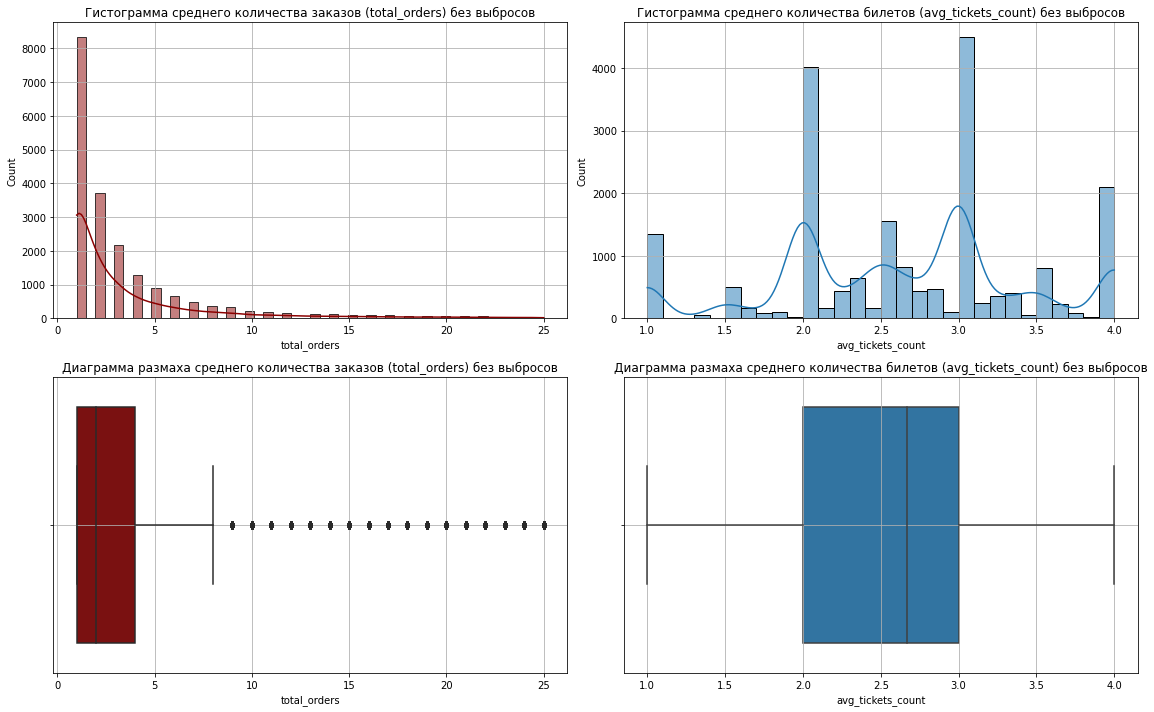

In [247]:
# Гистограммы и диаграммы размаха
fig, axes = plt.subplots(2, 2, figsize = (16, 10))

# Гистограмма для `total_orders` без выбросов
sns.histplot(filtered_user_profile['total_orders'], bins = 50, kde = True, ax = axes[0, 0], color = 'darkred')
axes[0, 0].set_title('Гистограмма среднего количества заказов (total_orders) без выбросов')
axes[0, 0].grid()

# Диаграмма размаха для `total_orders` без выбросов
sns.boxplot(data = filtered_user_profile, x = 'total_orders', ax = axes[1, 0], color = 'darkred')
axes[1, 0].set_title('Диаграмма размаха среднего количества заказов (total_orders) без выбросов')
axes[1, 0].grid()

# Гистограмма для `avg_tickets_count` без выбросов
sns.histplot(filtered_user_profile['avg_tickets_count'], bins = 30, kde = True, ax = axes[0, 1])
axes[0, 1].set_title('Гистограмма среднего количества билетов (avg_tickets_count) без выбросов')
axes[0, 1].grid()

# Диаграмма размаха для `avg_tickets_count` без выбросов
sns.boxplot(data = filtered_user_profile, x = 'avg_tickets_count', ax = axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха среднего количества билетов (avg_tickets_count) без выбросов')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

После удаления выбросов в столбце `total_orders` видно, что среднее количество заказов имеет большой разброс. Большинство пользователей сделали меньше 5 заказов.  Пик распределения смещен в левую сторону. Также, присутствует длинный "хвост" с правой стороны. 
Присутствует небольшая разница между медианой (3,5) и средним значением (2), что говорит о неравномерном распределении данных. На гистограмме это показано: большинство пользователей (больше 8000) сделали в среднем по одному заказу.
Большое максимальное значение max (25) указывает на большой разброс в данных.

В столбце `avg_tickets_count` видно, что в среднем, пользователи преобретают 4 билета на различные мероприятия. Данные имеют равномерное распределение.
Присутствует небольшая разница между медианой (2,66) и средним значением (2,63), что говорит о равномерном распределении данных. На гистограмме это показано: большинство пользователей (больше 4000) преобретали по 4 билета.

In [248]:
# Выведем отфильтрованный датасет
display(filtered_user_profile)

,user_id,min_order_dt,max_order_dt,device_type_canonical,region_name,service_name,event_type_main,total_orders,avg_revenue_rub,avg_tickets_count,average_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,0.00,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,74.81,False,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,50.91,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,0.00,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,15.62,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21825,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,7,621.661429,2.714286,17.81,True,True
21826,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,850.995000,2.500000,74.38,False,False
21827,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,Каменевский регион,Билеты без проблем,концерты,25,589.893600,2.680000,5.49,True,True
21828,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,661.530000,2.000000,0.00,False,False


* Выведем статистические показатели по обновлённому датасету

In [249]:
# Общее число пользователей в выборке
nunique = filtered_user_profile['user_id'].nunique()

# Средняя выручка с одного заказа
average_revenue_per_order = round(filtered_user_profile['avg_revenue_rub'].mean(), 3)

# Доля пользователей, совершивших более 2 заказов
share_more_than_two = round(filtered_user_profile['is_two'].mean() * 100, 2)

# Доля пользователей, совершивших более 5 заказов
share_more_than_five = round(filtered_user_profile['is_five'].mean() * 100, 2)

# общее число заказов
count_orders = filtered_user_profile['total_orders'].nunique()

# Среднее число билетов в заказе
average_tickets_per_order = round(filtered_user_profile.groupby('user_id')['avg_tickets_count'].mean().mean(), 2)

# Среднее количество дней между покупками
overall_average_days = round(filtered_user_profile.groupby('user_id')['average_time_between_orders'].mean().mean(), 2)

print(f'Общее число пользователей: {total_users}')
print(f'Средняя выручка с одного заказа: {average_revenue_per_order}')
print(f'Доля пользователей, совершивших более 2 заказов: {share_more_than_two}%')
print(f'Доля пользователей, совершивших более 5 заказов: {share_more_than_five}%')
print(f'Среднее общее число заказов: {count_orders}')
print(f'Среднее число билетов в заказе: {average_tickets_per_order}')
print(f'Среднее количество дней между покупками: {overall_average_days}')

Общее число пользователей: 19856
Средняя выручка с одного заказа: 530.307
Доля пользователей, совершивших более 2 заказов: 39.22%
Доля пользователей, совершивших более 5 заказов: 17.21%
Среднее общее число заказов: 25
Среднее число билетов в заказе: 2.64
Среднее количество дней между покупками: 11.46


**Промежуточный вывод**

Для создания профиля пользователя был отфильтрован исходный датафрейм по следующим параметрам: 

* общее число пользователей в выборке;
* средняя выручка с одного заказа;
* доля пользователей, совершивших более 2 и более 5 заказов.

Также были изучены статистические показатели:

* общее числуо заказов;
* среднее число билетов в заказе;
* среднее количество дней между покупками.

В ходе анализа было выявлено, что в столбцах `total_orders` и `avg_tickets_count` имеются аномальные значения (выбросы).
Данные выше 95-го перцентиля были удалены.

Финальный датафрейм содержит 19856 строк из 21830 исходных. Процент удаленных записей: 9.04 %.

После удаления выбросов в столбце `total_orders` видно, что среднее количество заказов имеет большой разброс. Большинство пользователей сделали меньше 5 заказов.  Пик распределения смещен в левую сторону. Также, присутствует длинный "хвост" с правой стороны. 
Присутствует небольшая разница между медианой (3,5) и средним значением (2), что говорит о неравномерном распределении данных. На гистограмме это показано: большинство пользователей (больше 8000) сделали в среднем по одному заказу.
Большое максимальное значение max (25) указывает на большой разброс в данных.

В столбце `avg_tickets_count` видно, что в среднем, пользователи преобретают 4 билета на различные мероприятия. Данные имеют равномерное распределение.
Присутствует небольшая разница между медианой (2,66) и средним значением (2,63), что говорит о равномерном распределении данных. На гистограмме это показано: большинство пользователей (больше 4000) преобретали по 4 билета.

После удаления аномальных значений, пол проведен повторный анализ статистических показателей по обновлённому датасету: 

Общее число пользователей: 19856

Средняя выручка с одного заказа: 530.307

Доля пользователей, совершивших более 2 заказов: 39.22%

Доля пользователей, совершивших более 5 заказов: 17.21%

Среднее общее число заказов: 25

Среднее число билетов в заказе: 2.64

Среднее количество дней между покупками: 19.76

---

## 4. Исследовательский анализ данных<a class="anchor" id="chapter4"></a>

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследем признаки, описывающие первый заказ пользователя, и выясним, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучим распределение пользователей по признакам.

- Сгруппируем пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
    
    
- Подсчитаем общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.

Исследуем распределения пользователей по первому типу мероприятия.

In [250]:
# Выведем количество пользователей по типу первого мероприятия
count_event_type = filtered_user_profile['event_type_main'].value_counts()

# Выведем долю пользователей по типу первого мероприятия
share_event_type = round(count_event_type / len(filtered_user_profile['user_id']) * 100, 2)

print(f'Количество пользователей по типу первого мероприятия:')
display(count_event_type)
print(f'Доля пользователей по типу первого мероприятия:')
display(share_event_type.apply(lambda x: f'{x}%'))

Количество пользователей по типу первого мероприятия:


концерты    8887
другое      4883
театр       3871
стендап     1029
спорт        705
выставки     394
ёлки          87
Name: event_type_main, dtype: int64

Доля пользователей по типу первого мероприятия:


концерты    44.76%
другое      24.59%
театр        19.5%
стендап      5.18%
спорт        3.55%
выставки     1.98%
ёлки         0.44%
Name: event_type_main, dtype: object

Построим график распределения пользователей по первому типу мероприятия.

Text(0, 0.5, 'Количество пользователей')

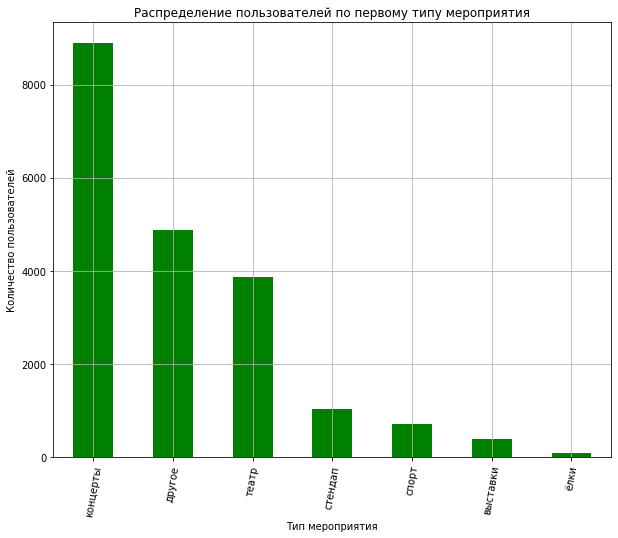

In [251]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

count_event_type.plot(kind = 'bar',
                      grid = True,
                      legend = False,
                      color = 'green',
                      rot = 80
)

plt.title('Распределение пользователей по первому типу мероприятия')
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество пользователей')

По результатам анализа видно, что самый популярный тип мероприятия - концерты, самые не популярные - выставки и ёлки.

Исследуем распределения пользователей по типу устройства, с которого совершена первая покупка.

In [252]:
# Выведем количество пользователей по типу устройства, с которого совершена первая покупка
count_device_type = filtered_user_profile['device_type_canonical'].value_counts()

# Выведем долю пользователей по типу устройства, с которого совершена первая покупка
share_device_type = round(count_device_type / len(filtered_user_profile['user_id']) * 100, 2)

print(f'Количество пользователей по типу устройства, с которого совершена первая покупка:')
display(count_device_type)
print(f'Доля пользователей по типу устройства, с которого совершена первая покупка:')
display(share_device_type.apply(lambda x: f'{x}%'))

Количество пользователей по типу устройства, с которого совершена первая покупка:


mobile     16496
desktop     3360
Name: device_type_canonical, dtype: int64

Доля пользователей по типу устройства, с которого совершена первая покупка:


mobile     83.08%
desktop    16.92%
Name: device_type_canonical, dtype: object

Построим график распределения пользователей по типу устройства, с которого совершена первая покупка.

Text(0, 0.5, 'Количество пользователей')

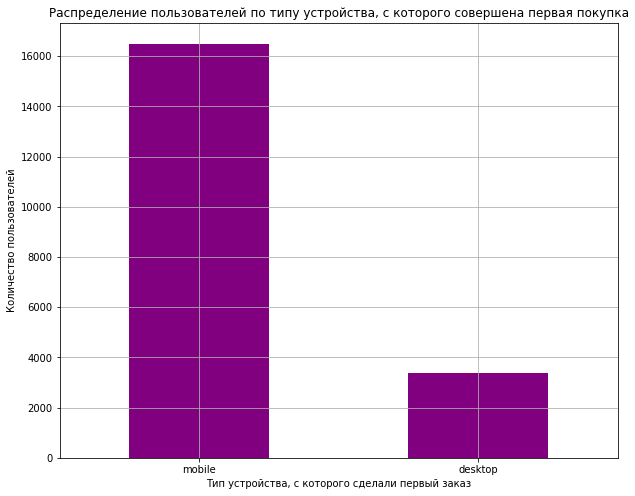

In [253]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

count_device_type.plot(kind = 'bar',
                       grid = True,
                       legend = False,                                        
                       color = 'purple',
                       rot = 0
)

plt.title('Распределение пользователей по типу устройства, с которого совершена первая покупка')
plt.xlabel('Тип устройства, с которого сделали первый заказ')
plt.ylabel('Количество пользователей')

По результатам анализа видно, что самый популярный тип устройства - мобильный телефон.

Исследуем распределения пользователей по региону проведения мероприятия из первого заказа.

In [254]:
# Выведем количество пользователей по региону проведения мероприятия из первого заказа
count_region = filtered_user_profile['region_name'].value_counts()

# Выведем долю пользователей по региону проведения мероприятия из первого заказа
share_region = round(count_region / len(filtered_user_profile['user_id']) * 100, 2)

print(f'Количество пользователей по региону проведения мероприятия из первого заказа:')
display(count_region)
print(f'Доля пользователей по региону проведения мероприятия из первого заказа:')
display(share_region.apply(lambda x: f'{x}%'))

Количество пользователей по региону проведения мероприятия из первого заказа:


Каменевский регион          6498
Североярская область        3410
Широковская область         1114
Озернинский край             630
Малиновоярский округ         500
                            ... 
Островогорский округ           2
Яснопольский округ             1
Верхозёрский край              1
Сосноводолинская область       1
Светолесский край              1
Name: region_name, Length: 81, dtype: int64

Доля пользователей по региону проведения мероприятия из первого заказа:


Каменевский регион          32.73%
Североярская область        17.17%
Широковская область          5.61%
Озернинский край             3.17%
Малиновоярский округ         2.52%
                             ...  
Островогорский округ         0.01%
Яснопольский округ           0.01%
Верхозёрский край            0.01%
Сосноводолинская область     0.01%
Светолесский край            0.01%
Name: region_name, Length: 81, dtype: object

Построим график распределения пользователей по региону проведения мероприятия из первого заказа. Выберем топ-10 регионов, из которых пользователе чаще делают заказы.

Text(0, 0.5, 'Количество пользователей')

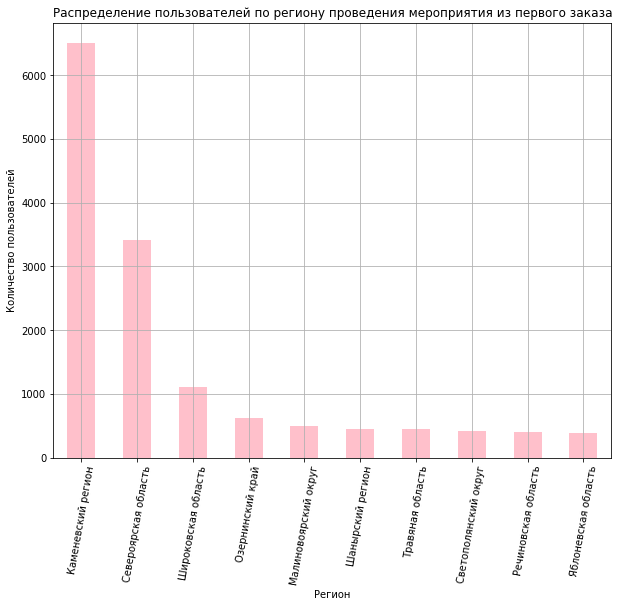

In [255]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

count_region.head(10).plot(kind = 'bar',
                           grid = True,
                           legend = False,                                        
                           color = 'pink',
                           rot = 80
)

plt.title('Распределение пользователей по региону проведения мероприятия из первого заказа')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')

Самые популярные регионы: Каменевский регион (6498 пользователей), Североярская область (3410 пользователей), Широковская область (1114 пользователей). 

Самые непопулярные регионы: Верхозёрский край, Сосноводолинская область, Светолесский край,  Яснопольский округ. В этих регионах по 1 пользователю.

Исследуем распределения пользователей по билетному оператору, продавшему билеты на первый заказ.

In [256]:
# Выведем количество пользователей по билетному оператору, продавшему билеты на первый заказ
count_service = filtered_user_profile['service_name'].value_counts()

# Выведем долю пользователей по билетному оператору, продавшему билеты на первый заказ
share_service = round(count_service / len(filtered_user_profile['user_id']) * 100, 2)

print(f'Количество пользователей по билетному оператору, продавшему билеты на первый заказ:')
display(count_service)
print(f'Доля пользователей по типу билетному оператору, продавшему билеты на первый заказ:')
display(share_service.apply(lambda x: f'{x}%'))

Количество пользователей по билетному оператору, продавшему билеты на первый заказ:


Билеты без проблем        4752
Мой билет                 2715
Лови билет!               2586
Билеты в руки             2332
Облачко                   2066
Весь в билетах            1173
Лучшие билеты             1070
Прачечная                  524
Край билетов               418
Дом культуры               323
Яблоко                     292
Тебе билет!                278
Городской дом культуры     194
Мир касс                   191
За билетом!                182
Show_ticket                151
Быстробилет                148
Выступления.ру              88
Восьмёрка                   77
Быстрый кассир              53
Crazy ticket!               43
Росбилет                    39
Радио ticket                34
Реестр                      27
Телебилет                   26
Цвет и билет                20
Шоу начинается!             17
КарандашРУ                  12
Кино билет                   8
Вперёд!                      7
Билет по телефону            5
Лимоны                       2
Тех биле

Доля пользователей по типу билетному оператору, продавшему билеты на первый заказ:


Билеты без проблем        23.93%
Мой билет                 13.67%
Лови билет!               13.02%
Билеты в руки             11.74%
Облачко                    10.4%
Весь в билетах             5.91%
Лучшие билеты              5.39%
Прачечная                  2.64%
Край билетов               2.11%
Дом культуры               1.63%
Яблоко                     1.47%
Тебе билет!                 1.4%
Городской дом культуры     0.98%
Мир касс                   0.96%
За билетом!                0.92%
Show_ticket                0.76%
Быстробилет                0.75%
Выступления.ру             0.44%
Восьмёрка                  0.39%
Быстрый кассир             0.27%
Crazy ticket!              0.22%
Росбилет                    0.2%
Радио ticket               0.17%
Реестр                     0.14%
Телебилет                  0.13%
Цвет и билет                0.1%
Шоу начинается!            0.09%
КарандашРУ                 0.06%
Кино билет                 0.04%
Вперёд!                    0.04%
Билет по т

Построим график распределения пользователей по билетному оператору, продавшему билеты на первый заказ.

Text(0, 0.5, 'Количество пользователей')

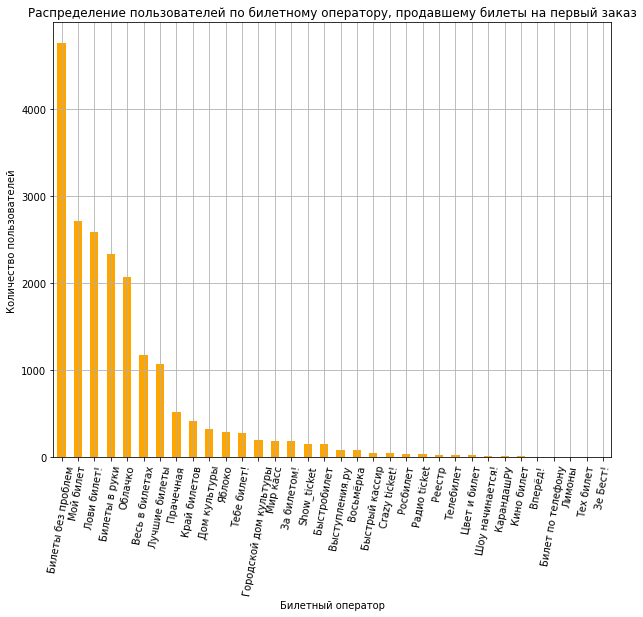

In [257]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

count_service.plot(kind = 'bar',
                   grid = True,
                   legend = False,                                        
                   color = 'orange',
                   rot = 80
)

plt.title('Распределение пользователей по билетному оператору, продавшему билеты на первый заказ')
plt.xlabel('Билетный оператор')
plt.ylabel('Количество пользователей')

Самые популярные билетные операторы: Билеты без проблем (4752 пользователей), Мой билет (2715 пользователей), Лови билет! (2586 пользователей), Билеты в руки (2332 пользователей), Облачко (2066 пользователей), Весь в билетах (1173 пользователей), Лучшие билеты (1070 пользователей).

Самые не популярные билетные операторы: Лимоны (2 пользователя), Тех билет (2 пользователя), Зе Бест! (1 пользователь).

**Промежуточный вывод**

В ходе исследования данных были выявлены следующие результаты: 

* **По типу первого мероприятия.** Самый популярный тип мероприятия - концерты (44,76 %), самые не популярные - выставки (1,98 %) и ёлки (0,44 %);
* **По типу устройства, с которого совершена первая покупка.** Мобильный телефон - самый популярный тип устройста (83,08 %), у компьютера - 16,92 %;
* **По региону проведения мероприятия из первого заказа.** Самые популярные регионы проведения мероприятий: 
    * Каменевский регион (32,73 %);
    * Североярская область (17,17 %);
    * Широковская область (5,6 %).

Самые непопулярные регионы: Верхозёрский край, Сосноводолинская область, Светолесский край, Яснопольский округ. В этих регионах по 0,01 %;
* **По билетному оператору, продавшему билеты на первый заказ.** Самые популярные билетные операторы: 
    * Билеты без проблем (23,93 %);
    * Мой билет (13,67 %);
    * Лови билет! (13,02 %);
    * Билеты в руки (11,74 %);
    * Облачко (10,40 %).
    
Самые не популярные билетные операторы: Лимоны, Тех билет, Зе Бест! - по 0,01 %.

---

**Задача 4.1.2.** Проанализируем возвраты пользователей:

- Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа.

In [258]:
# Группируем пользователей по типу первого мероприятия
grouped_by_event_type = filtered_user_profile.groupby('event_type_main')
share_is_two_by_event_type = round(grouped_by_event_type.apply(lambda x: (x['is_two'].sum() / len(x)) * 100).sort_values(ascending = False), 2)

# Группируем пользователей по типу устройства
grouped_by_device_type = filtered_user_profile.groupby('device_type_canonical')
share_is_two_device_type = round(grouped_by_device_type.apply(lambda x: (x['is_two'].sum() / len(x)) * 100).sort_values(ascending = False), 2)

# Группируем пользователей по региону проведения мероприятия из первого заказа
grouped_by_region = filtered_user_profile.groupby('region_name')
share_is_two_region = round(grouped_by_region.apply(lambda x: (x['is_two'].sum() / len(x)) * 100).sort_values(ascending = False), 2)

# Группируем пользователей по билетному оператору, продавшему билеты на первый заказ
grouped_by_service = filtered_user_profile.groupby('service_name')
share_is_two_service = round(grouped_by_service.apply(lambda x: (x['is_two'].sum() / len(x)) * 100).sort_values(ascending = False), 2)

print('Доля пользователей, совершивших два и более заказа, по типу первого мероприятия:')
display(share_is_two_by_event_type.apply(lambda x: f'{x}%'))
print('Доля пользователей, совершивших два и более заказа, по типу устройства:')
display(share_is_two_device_type.apply(lambda x: f'{x}%'))
print('Доля пользователей, совершивших два и более заказа, по региону проведения мероприятия из первого заказа:')
display(share_is_two_region.apply(lambda x: f'{x}%'))
print('Доля пользователей, совершивших два и более заказа, по билетному оператору, продавшему билеты на первый заказ:')
display(share_is_two_service.apply(lambda x: f'{x}%'))

Доля пользователей, совершивших два и более заказа, по типу первого мероприятия:


event_type_main
театр       40.64%
другое      39.63%
выставки    39.59%
концерты    38.89%
стендап     38.29%
спорт       35.04%
ёлки        31.03%
dtype: object

Доля пользователей, совершивших два и более заказа, по типу устройства:


device_type_canonical
desktop    41.99%
mobile     38.66%
dtype: object

Доля пользователей, совершивших два и более заказа, по региону проведения мероприятия из первого заказа:


region_name
Озернопольская область     52.0%
Тихогорская область        50.0%
Лесостепной край           50.0%
Радужнопольский край      47.62%
Берёзовская область       47.17%
                           ...  
Крутоводский регион         0.0%
Залесский край              0.0%
Верхозёрский край           0.0%
Верховинская область        0.0%
Яснопольский округ          0.0%
Length: 81, dtype: object

Доля пользователей, совершивших два и более заказа, по билетному оператору, продавшему билеты на первый заказ:


service_name
Зе Бест!                  100.0%
Билет по телефону          60.0%
Реестр                    59.26%
Восьмёрка                 57.14%
Цвет и билет               55.0%
Быстрый кассир            54.72%
Crazy ticket!             51.16%
Тех билет                  50.0%
Лимоны                     50.0%
Край билетов               48.8%
Росбилет                  43.59%
Прачечная                 42.37%
Дом культуры              42.11%
Городской дом культуры    40.72%
Билеты в руки             40.69%
Show_ticket                40.4%
Мир касс                  40.31%
Билеты без проблем        39.77%
Лучшие билеты             39.07%
Мой билет                 38.49%
Весь в билетах            38.45%
Лови билет!               37.86%
За билетом!               37.36%
Облачко                   37.27%
Быстробилет               36.49%
Выступления.ру            36.36%
Тебе билет!               34.53%
Яблоко                    31.51%
Радио ticket              26.47%
Телебилет                 23.0

* Визуализируем полученный результат. Для столбцов `region_name` и `service_name` поместим на график только 10 сегментов с наибольшим количеством пользователей.

Text(0, 0.5, 'Доля пользователей, %')

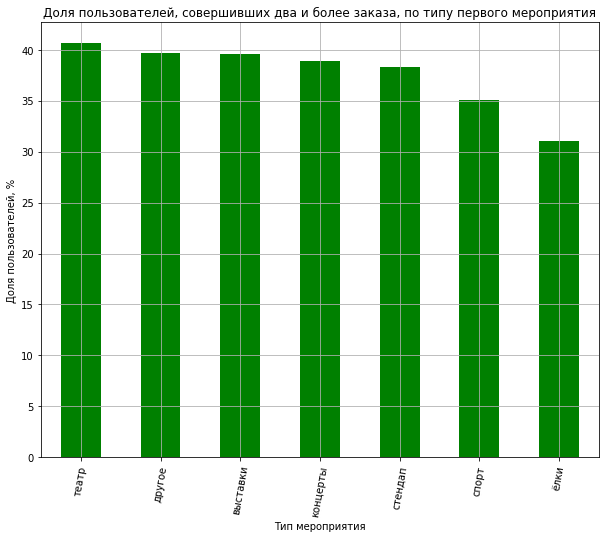

In [259]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

share_is_two_by_event_type.plot(kind = 'bar',
                      grid = True,
                      legend = False,
                      color = 'green',
                      rot = 80
)

plt.title('Доля пользователей, совершивших два и более заказа, по типу первого мероприятия')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля пользователей, %')

Text(0, 0.5, 'Доля пользователей, %')

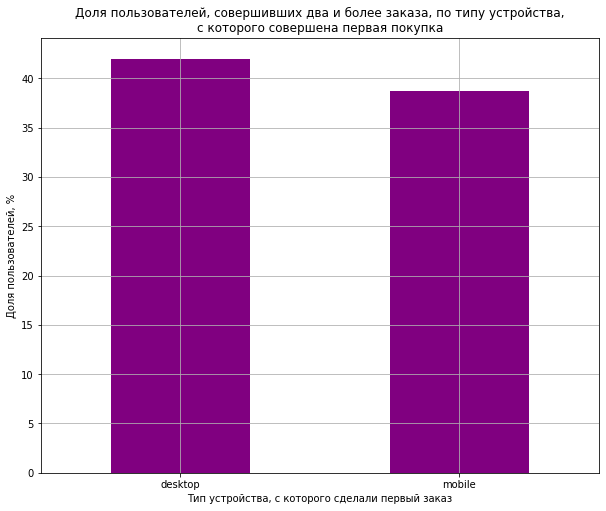

In [260]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

share_is_two_device_type.plot(kind = 'bar',
                       grid = True,
                       legend = False,                                        
                       color = 'purple',
                       rot = 0
)

plt.title('Доля пользователей, совершивших два и более заказа, по типу устройства,\nс которого совершена первая покупка')
plt.xlabel('Тип устройства, с которого сделали первый заказ')
plt.ylabel('Доля пользователей, %')

Text(0, 0.5, 'Доля пользователей, %')

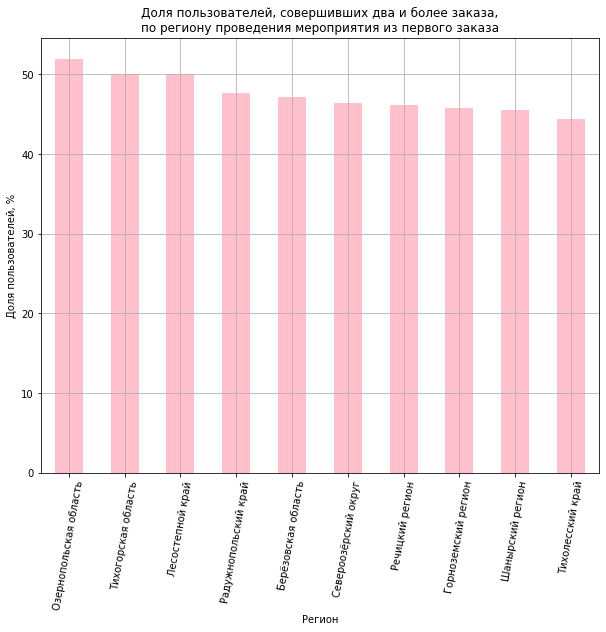

In [261]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

share_is_two_region.head(10).plot(kind = 'bar',
                           grid = True,
                           legend = False,                                        
                           color = 'pink',
                           rot = 80
)

plt.title('Доля пользователей, совершивших два и более заказа,\nпо региону проведения мероприятия из первого заказа')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей, %')

Text(0, 0.5, 'Доля пользователей, %')

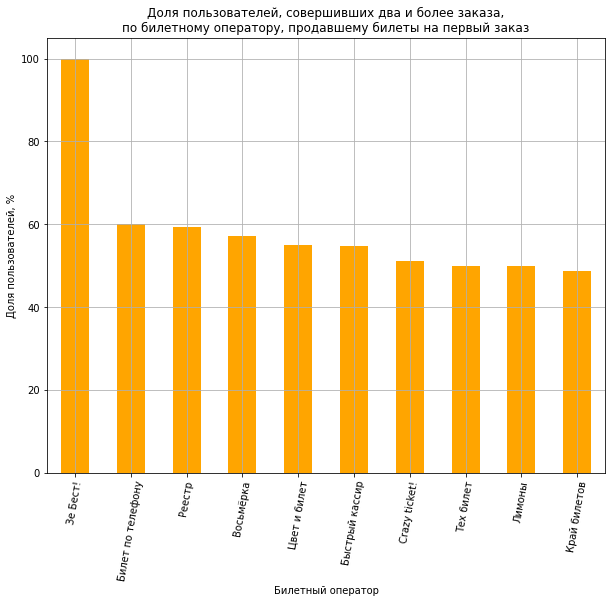

In [262]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

share_is_two_service.head(10).plot(kind = 'bar',
                   grid = True,
                   legend = False,                                        
                   color = 'orange',
                   rot = 80
)

plt.title('Доля пользователей, совершивших два и более заказа,\nпо билетному оператору, продавшему билеты на первый заказ')
plt.xlabel('Билетный оператор')
plt.ylabel('Доля пользователей, %')

**Промежуточный вывод**

* **Сегмент "по типу первого мероприятия".** Доля пользователей, совершивших более двух заказов, имеет почти одинаковое процентное соотношение. Максимальная доля у "театр" - 40,64%, минимальная доля у "ёлки" - 31,03%;

* **Сегмент "по типу устройства, с которого сделали первый заказ"**. Доля пользователей, совершивших более двух заказов, почти одинакова. У станиорарного компьютера - 41,99%, у мобильного устройства - 38,66%;

* **Сегмент "по региону проведения мероприятия из первого заказа".** Доля пользователей, совершивших более двух заказов, имеет почти одинаковое распределение для топ-10 регионов с наибольшим количеством пользователей. Максимальное значение у Озернопольской области - 52,0%;

* **Сегмент "по билетному оператору, продавшему билеты на первый заказ".** Доля пользователей, совершивших более двух заказов, имеет почти одинаковое распределение для топ-10 операторов, продавшему билеты на первый заказ. Однако, у оператора "Зе Бест!" 100% пользователей всегда совершают повторный заказ. На втором месте "Билет по телефону" - 60,0%, а минимальное количество пользователей у "Край билетов" - 48,8%.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверим продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

In [263]:
# Доля пользователей, которые совершили первый заказ на спортивные мероприятия и вернулись на платформу
sports_events_share = share_is_two_by_event_type['спорт']
# Доля пользователей, которые совершили первый заказ на концерты и вернулись на платформу
concerts_share = share_is_two_by_event_type['театр']

print(f'Доля пользователей, совершивших два и более заказа на спортивные мероприятия: {sports_events_share}%')
print(f'Доля пользователей, совершивших два и более заказа на театры: {concerts_share}%')

Доля пользователей, совершивших два и более заказа на спортивные мероприятия: 35.04%
Доля пользователей, совершивших два и более заказа на театры: 40.64%


Доля на спортивные мероприятия (35,04%) меньше, чем доля пользователей, которые преобретают билеты на театры (40,64%). Таким образом, тип мероприятия не влияет на вероятность возврата пользователей на Яндекс Афишу.

- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

In [264]:
# Преодразуем в датафреймы строки
share_region = pd.DataFrame(share_region)
share_is_two_region = pd.DataFrame(share_is_two_region)

# Объединение строк по индексу
merged_share_region = pd.merge(share_region, share_is_two_region, left_index=True, right_index=True)
merged_share_region.columns = ['Частота посещений мероприятий', 'Доля повторных заказов']
merged_share_region.sort_values(by = 'Частота посещений мероприятий', ascending = False)

print(merged_share_region)

                          Частота посещений мероприятий  \
Каменевский регион                                32.73   
Североярская область                              17.17   
Широковская область                                5.61   
Озернинский край                                   3.17   
Малиновоярский округ                               2.52   
...                                                 ...   
Островогорский округ                               0.01   
Яснопольский округ                                 0.01   
Верхозёрский край                                  0.01   
Сосноводолинская область                           0.01   
Светолесский край                                  0.01   

                          Доля повторных заказов  
Каменевский регион                         40.97  
Североярская область                       42.99  
Широковская область                        40.48  
Озернинский край                           29.68  
Малиновоярский округ                

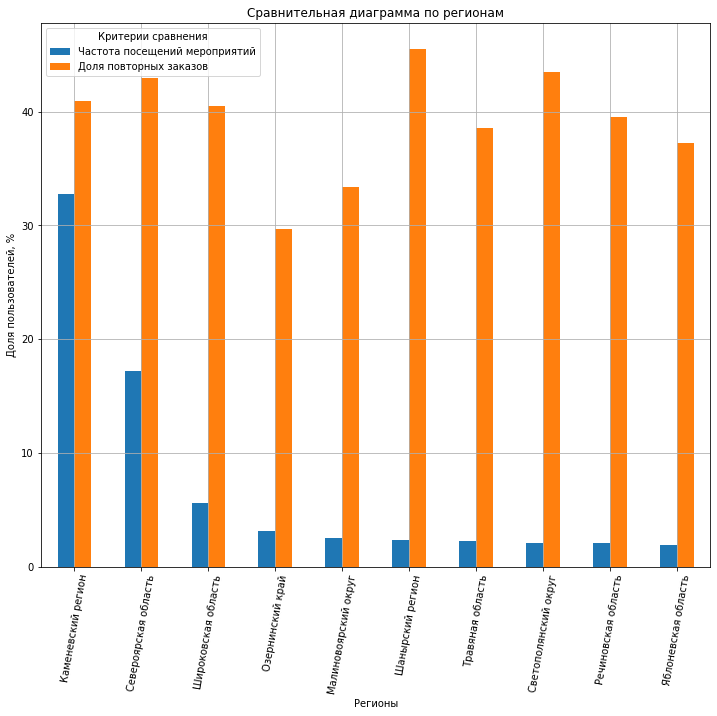

In [265]:
# Построим столбчатую диаграмму
merged_share_region.head(10).plot(kind = 'bar',
                    figsize = (12, 10),
                   grid = True,
                   legend = True,                                        
                   rot = 80
)

plt.title('Сравнительная диаграмма по регионам')
plt.xlabel('Регионы')
plt.ylabel('Доля пользователей, %')
plt.legend(title = 'Критерии сравнения', labels = ['Частота посещений мероприятий', 'Доля повторных заказов'])

Из графика видно, что по регионам, частота посещения пользователей мероприятий не влияет на долю покупки билетов. 

Доля покупки билетов примерно одинакова в топ-10 активных регионов.

Таким образом, частота посещений мероприятий не влияет на вероятность возврата пользователей на Яндекс Афишу.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследим связь между средней выручкой сервиса с заказа и повторными заказами.

- Построим сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
    
        
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

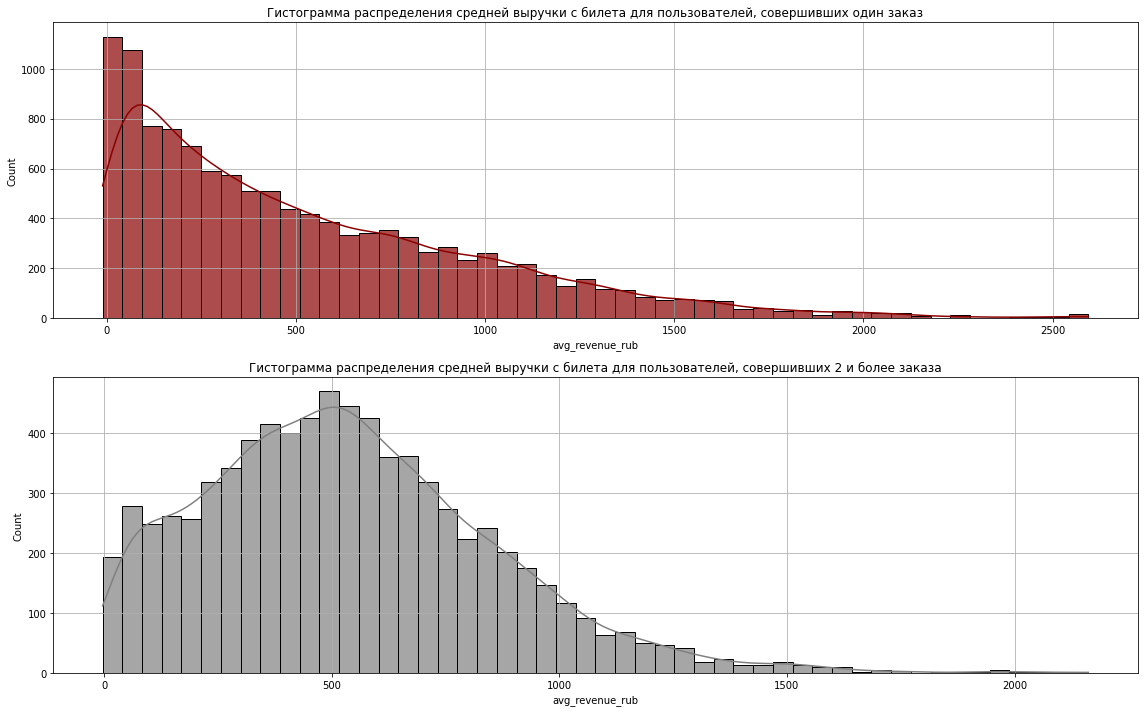

In [266]:
# Фильтрация пользователей, совершивших один заказ
one_order_users = filtered_user_profile[(filtered_user_profile['is_two'] == False) & (filtered_user_profile['is_five'] == False)]

# Фильтрация вернувшихся пользователей, совершивших 2 и более заказа
multiple_orders_users = filtered_user_profile[filtered_user_profile['is_two'] == True]

# Гистограммы
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Гистограмма для пользователей, совершивших один заказ
sns.histplot(one_order_users['avg_revenue_rub'], bins=50, alpha=0.7, kde=True, ax=axes[0], color='darkred')
axes[0].set_title('Гистограмма распределения средней выручки с билета для пользователей, совершивших один заказ')
axes[0].grid()

# Гистограмма для вернувшихся пользователей
sns.histplot(multiple_orders_users['avg_revenue_rub'], bins=50, alpha=0.7, kde=True, ax=axes[1], color='gray')
axes[1].set_title('Гистограмма распределения средней выручки с билета для пользователей, совершивших 2 и более заказа')
axes[1].grid()

plt.tight_layout()
plt.show()

In [267]:
# Метрики средней выручки по пользователям, совершивших один заказ
one_order_users['avg_revenue_rub'].describe()

count    12068.000000
mean       527.487417
std        469.608623
min        -10.770000
25%        149.085000
50%        398.760000
75%        790.910000
max       2594.440000
Name: avg_revenue_rub, dtype: float64

In [268]:
# Метрики средней выручки по пользователям, совершивших 2 и более заказа
multiple_orders_users['avg_revenue_rub'].describe()

count    7788.000000
mean      534.675146
std       315.152876
min        -3.203333
25%       307.131000
50%       507.793500
75%       725.347179
max      2162.033333
Name: avg_revenue_rub, dtype: float64

**Промежуточный вывод**

Распределения средней выручки с билета для пользователей, совершивших один заказ:

* количество пользователей - 12068;
* пик распределения смещен в левую сторону; 
* присутствует длинный "хвост" с правой стороны; 
* большая разница между медианой (398,8) и средним значением (527,5), что говорит о неравномерном распределении данных;
* большое максимальное значение max (2594,4) указывает на большой разброс в данных; 
* меются отрицательные значения, что говорит о возвратах;
* средняя выручка концентрируется в диапазоне от -10 до 1000;
* при максимальном количестве пользователей (от 500 до 1000), средняя выручка меньше 500.

Распределения средней выручки с билета для пользователей, совершивших 2 и более заказа:

* количество пользователей - 7788;
* пик распределения смещен к значению 500; 
* присутствует длинный "хвост" с правой стороны; 
* небольшая разница между медианой (507,8) и средним значением (534,7), что говорит об относительно равномерном распределении данных;
* большое максимальное значение max (2162) указывает на большой разброс в данных; 
* меются отрицательные значения, что говорит о возвратах;
* средняя выручка концентрируется в диапазоне от -10 до 1000;
* при максимальном количестве пользователей (больше 500), средняя выручка варьируется примерно от 250 до 650.

Таким образом, распределения количества пользователей отличаются при значении выручки меньше 1000. При выручке больше 1000, распределение пользователей примерно одинаково.

---

**Задача 4.2.2.** Сравним распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


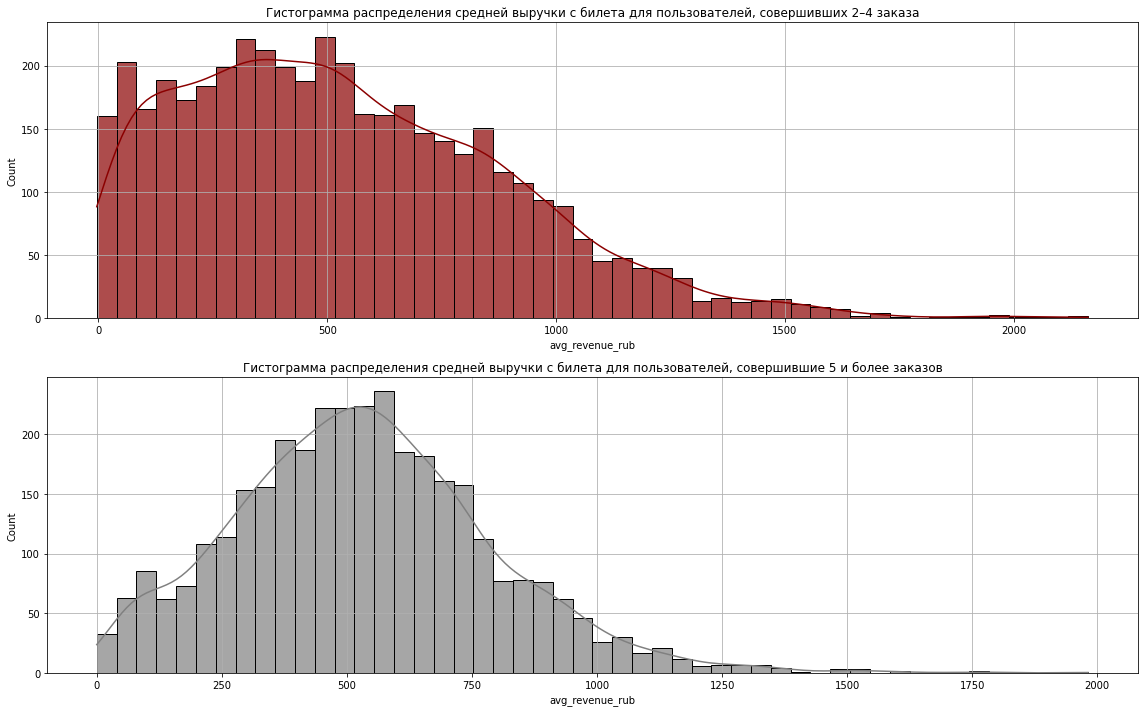

In [269]:
# Фильтрация пользователей, совершивших 2–4 заказа
two_four_order_users = filtered_user_profile[(filtered_user_profile['is_two'] == True) & (filtered_user_profile['is_five'] == False)]

# Фильтрация вернувшихся пользователей, совершившие 5 и более заказов
more_five_orders_users = filtered_user_profile[filtered_user_profile['is_five'] == True]

# Гистограммы
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Гистограмма для пользователей, совершивших один заказ
sns.histplot(two_four_order_users['avg_revenue_rub'], bins=50, alpha=0.7, kde=True, ax=axes[0], color='darkred')
axes[0].set_title('Гистограмма распределения средней выручки с билета для пользователей, совершивших 2–4 заказа')
axes[0].grid()

# Гистограмма для вернувшихся пользователей
sns.histplot(more_five_orders_users['avg_revenue_rub'], bins=50, alpha=0.7, kde=True, ax=axes[1], color='gray')
axes[1].set_title('Гистограмма распределения средней выручки с билета для пользователей, совершившие 5 и более заказов')
axes[1].grid()

plt.tight_layout()
plt.show()

In [270]:
# Метрики средней выручки по пользователям, совершивших 2–4 заказа
two_four_order_users['avg_revenue_rub'].describe()

count    4370.000000
mean      536.268098
std       353.785822
min        -3.203333
25%       259.732901
50%       491.944583
75%       769.553333
max      2162.033333
Name: avg_revenue_rub, dtype: float64

In [271]:
# Метрики средней выручки по пользователям, совершившие 5 и более заказов
more_five_orders_users['avg_revenue_rub'].describe()

count    3418.000000
mean      532.638517
std       257.487622
min         0.000000
25%       357.998250
50%       521.105000
75%       685.149107
max      1981.547500
Name: avg_revenue_rub, dtype: float64

**Промежуточный вывод**

Распределения средней выручки с билета для пользователей, совершивших 2–4 заказа:

* количество пользователей - 4370;
* пик распределения смещен в левую сторону;
* присутствует длинный "хвост" с правой стороны;
* большая разница между медианой (491,9) и средним значением (536,3), что говорит о неравномерном распределении данных;
* большое максимальное значение max (2162) указывает на большой разброс в данных;
* меются отрицательные значения, что говорит о возвратах;
* средняя выручка концентрируется в диапазоне от -3 до 500;
* при максимальном количестве пользователей (от 150 до 250), средняя выручка меньше 500. Распределение пользвателейв этом диапазоне выручки примерно одинаково.

Распределения средней выручки с билета для пользователей, совершившие 5 и более заказов:

* количество пользователей - 3418;
* пик распределения смещен к значению 500;
* присутствует длинный "хвост" с правой стороны;
* небольшая разница между медианой (521,1) и средним значением (532,6), что говорит об относительно равномерном распределении данных;
* большое максимальное значение max (1981,5) указывает на большой разброс в данных;
* возвраты отсутствуют;
* средняя выручка концентрируется в диапазоне от 0 до 1000;
* при максимальном количестве пользователей (больше 200), средняя выручка варьируется примерно от 400 до 650.

Таким образом, распределения количества пользователей отличаются при значении выручки меньше 1000. При выручке больше 1000, распределение пользователей примерно одинаково.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучим распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишем основные наблюдения.

In [272]:
# Выведем метрики для столбца `avg_tickets_count`
print('Статистические показатели для столбца avg_tickets_count:')
filtered_user_profile['avg_tickets_count'].describe()

Статистические показатели для столбца avg_tickets_count:


count    19856.000000
mean         2.635150
std          0.790371
min          1.000000
25%          2.000000
50%          2.666667
75%          3.000000
max          4.000000
Name: avg_tickets_count, dtype: float64

Визуализируем распределение пользователей по среднему количеству билетов в заказе.

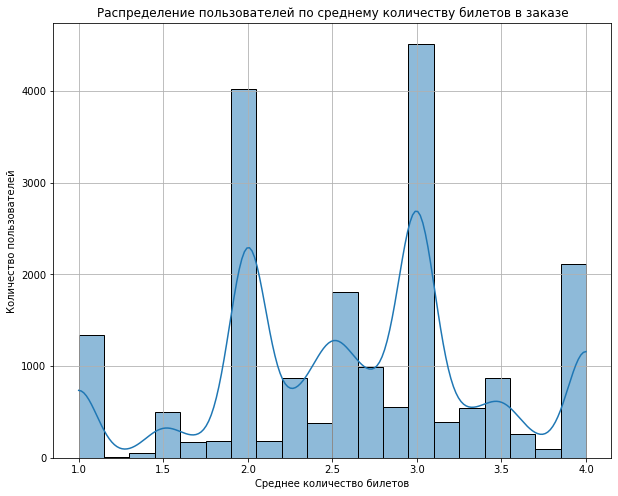

In [273]:
# Построим гистограмму
sns.histplot(data = filtered_user_profile, x = 'avg_tickets_count', bins=20, kde=True)
plt.gcf().set_size_inches(10, 8)
plt.grid(True)
plt.title('Распределение пользователей по среднему количеству билетов в заказе')
plt.xlabel('Среднее количество билетов')
plt.ylabel('Количество пользователей')
plt.show()

По результатам анализа распределения пользователей по среднему количеству билетов в заказе:

* значение медианы (2,67) почти совпадает со средним значением (2,64), что говорит о равномерном распределении данных;
* низкое значение среднеквадратичного откронения (0,79) указывает на минимальный разброс данных; 
* выбросы отсутствуют. 

На гистограмме видно, что большинство пользователей (больше 4000) преобретают по 2-3 билета за один заказ.

- Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.

In [274]:
list_tickets_count = {
    '1-2 билетов': (filtered_user_profile['avg_tickets_count'] >= 1) & (filtered_user_profile['avg_tickets_count'] < 2),
    '2-3 билетов': (filtered_user_profile['avg_tickets_count'] >= 2) & (filtered_user_profile['avg_tickets_count'] < 3),
    '3-5 билетов': (filtered_user_profile['avg_tickets_count'] >= 3) & (filtered_user_profile['avg_tickets_count'] <= 5),
    '5 и более билетов': filtered_user_profile['avg_tickets_count'] > 5
}

Построим визуализацию сегментов пользователей по среднему количеству билетов в заказе.

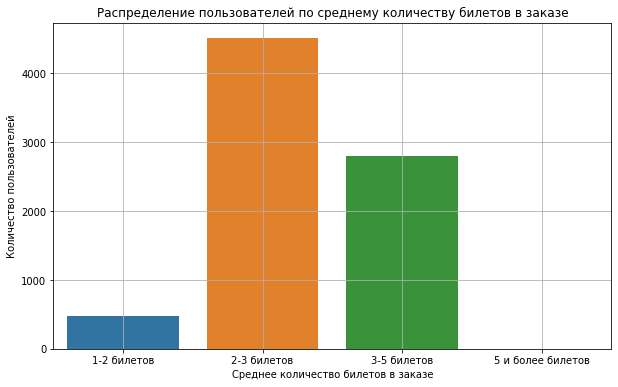

In [275]:
# Строим гистограмму
plt.figure(figsize = (10, 6))
sns.barplot(x = list(segment_counts.keys()), y = list(segment_counts.values()))
plt.grid(True)
plt.title('Распределение пользователей по среднему количеству билетов в заказе')
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Количество пользователей')
plt.show()

- Для каждого сегмента подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы.

In [276]:
# Подсчёт общего количества пользователей в каждом сегменте
total_segment_counts = {}
for segment, condition in list_tickets_count.items():
    total_segment_counts[segment] = filtered_user_profile[condition].shape[0]

# Подсчёт числа пользователей в каждом сегменте, совершивших повторные заказы
segment_counts = {}
for segment, condition in list_tickets_count.items():
    segment_counts[segment] = filtered_user_profile[condition & ((filtered_user_profile['is_two'] == True) | (filtered_user_profile['is_five'] == True))].shape[0]

# Вывод результатов
print('Общее число пользователей в каждом сегменте:')
for segment, count in total_segment_counts.items():
    print(f'{segment}: {count}')

print('\nОбщее число пользователей в каждом сегменте, совершивших повторные заказы:')
for segment, count in segment_counts.items():
    print(f'{segment}: {count}')

Общее число пользователей в каждом сегменте:
1-2 билетов: 2280
2-3 билетов: 8800
3-5 билетов: 8776
5 и более билетов: 0

Общее число пользователей в каждом сегменте, совершивших повторные заказы:
1-2 билетов: 482
2-3 билетов: 4508
3-5 билетов: 2798
5 и более билетов: 0


In [277]:
# Подсчёт доли пользователей, совершивших повторные заказы
segment_repeat_purchase_ratio = {}
for segment in segment_counts:
    if total_segment_counts[segment] == 0:
        segment_repeat_purchase_ratio[segment] = 0
    else:
        segment_repeat_purchase_ratio[segment] = segment_counts[segment] / total_segment_counts[segment]

print('Доля пользователей, совершивших повторные заказы в каждом сегменте:')
for segment, ratio in segment_repeat_purchase_ratio.items():
    print(f'{segment}: {ratio:.2f}%')

Доля пользователей, совершивших повторные заказы в каждом сегменте:
1-2 билетов: 0.21%
2-3 билетов: 0.51%
3-5 билетов: 0.32%
5 и более билетов: 0.00%


Построим визуализацию распределения доли пользователей в каждом сегменте, совершивших повторные заказы.

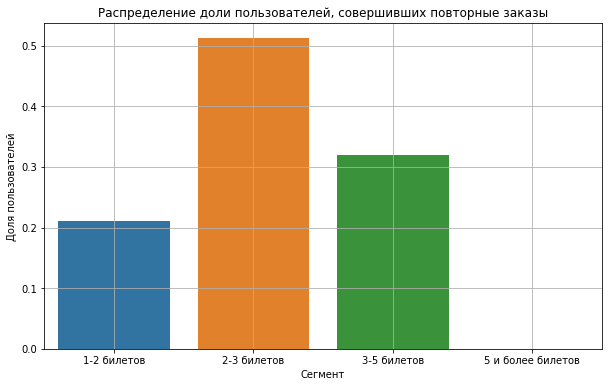

In [278]:
# Подготавливаем данные для графика
segments = list(segment_repeat_purchase_ratio.keys())
ratios = list(segment_repeat_purchase_ratio.values())

# Создаём график
plt.figure(figsize=(10, 6))
sns.barplot(x = segments, y = ratios)
plt.grid(True)
plt.title('Распределение доли пользователей, совершивших повторные заказы')
plt.xlabel('Сегмент')
plt.ylabel('Доля пользователей')
plt.show()

- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

**Промежуточный вывод**

Распределение пользователей по сегментам неравномерно. Данные пользователей, которые совершившие 5 и более заказов, были в зоне выбросов. После фильтрации данные по 99-му квантилю, эти данные не учитываются.

Общее число пользователей в каждом сегменте:

* 1-2 билетов: 2280
* 2-3 билетов: 8800
* 3-5 билетов: 8776
* 5 и более билетов: 0

Пользователи не преобретают больше 4 билетов.

Доля пользователей, совершивших повторные заказы в каждом сегменте:

* 1-2 билетов: 0.21%
* 2-3 билетов: 0.51%
* 3-5 билетов: 0.32%
* 5 и более билетов: 0.00%

Пользователи чаще преобретают по 2-3 билета при повторных заказах.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучим временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируем, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделим день недели.

In [279]:
# Извлечём из даты первого заказа день недели
day_of_first_buy = filtered_user_profile['min_order_dt'].dt.day_name()

- Для каждого дня недели подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируем.

In [280]:
# Извлечём из даты первого заказа день недели
day_of_first_buy = filtered_user_profile['min_order_dt'].dt.day_name()

# Подсчитаем общее число пользователей для каждого дня недели
total_users_by_day = day_of_first_buy.value_counts()

# Определим пользователей, совершивших повторные заказы
repeated_users = filtered_user_profile[(filtered_user_profile['is_two'] == True) | (filtered_user_profile['is_five'] == True)]

# Группируем данные по дню недели и подсчитываем количество пользователей с повторными заказами
repeated_users_by_day = (
    repeated_users
    .groupby(day_of_first_buy)['user_id']
    .nunique()
)

# Рассчитаем долю пользователей с повторными заказами для каждого дня недели
repeated_users_ratio = repeated_users_by_day / total_users_by_day

# Вывод результатов
print('Общее число пользователей для каждого дня недели:')
display(total_users_by_day)

print('\nОбщее число пользователей с повторными заказами, для каждого дня недели:')
display(repeated_users_by_day)

print('\nДоля пользователей с повторными заказами для каждого дня недели:')
for day, ratio in repeated_users_ratio.items():
    print(f'{day}: {ratio:.2%}') 

Общее число пользователей для каждого дня недели:


Friday       3018
Saturday     2986
Thursday     2896
Tuesday      2892
Wednesday    2829
Monday       2712
Sunday       2523
Name: min_order_dt, dtype: int64


Общее число пользователей с повторными заказами, для каждого дня недели:


min_order_dt
Friday       1170
Monday       1109
Saturday     1176
Sunday        969
Thursday     1105
Tuesday      1155
Wednesday    1104
Name: user_id, dtype: int64


Доля пользователей с повторными заказами для каждого дня недели:
Friday: 38.77%
Monday: 40.89%
Saturday: 39.38%
Sunday: 38.41%
Thursday: 38.16%
Tuesday: 39.94%
Wednesday: 39.02%


Text(0, 0.5, 'Доля пользователей, %')

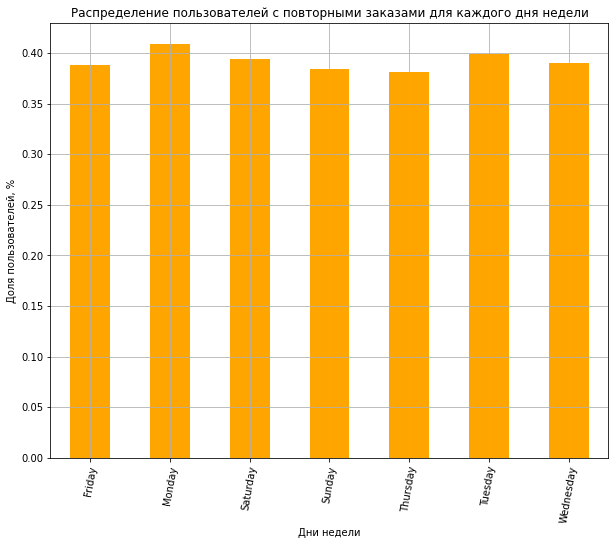

In [281]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

repeated_users_ratio.plot(kind = 'bar',
                   grid = True,
                   legend = False,                                        
                   color = 'orange',
                   rot = 80
)

plt.title('Распределение пользователей с повторными заказами для каждого дня недели')
plt.xlabel('Дни недели')
plt.ylabel('Доля пользователей, %')

Общее число пользователей для каждого дня недели варьируется незначительно, как и доля пользователей с повторными заказами для каждого дня недели. 

Таким образом, день недели, в которую была совершена первая покупка, не влияет на вероятность возврата клиента.

---

**Задача 4.3.2.** Изучим, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитаем среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.

In [282]:
# Среднее время между заказами для пользователей, совершившие 2–4 заказа
time_two_four_orders = (filtered_user_profile.loc[(filtered_user_profile['is_two'] == True) & (filtered_user_profile['is_five'] == False), 'average_time_between_orders']).mean()

# Среднее время между заказами для пользователей, совершившие 5 и более заказов
time_five_more_orders = (filtered_user_profile.loc[(filtered_user_profile['is_two'] == False) & (filtered_user_profile['is_five'] == True), 'average_time_between_orders']).mean()

print('Среднее время между заказами для пользователей, совершившие 2–4 заказа: ')
print(f'{time_two_four_orders:.2f}%')
print('Среднее время между заказами для пользователей, совершившие 5 и более заказов: ')
print(f'{time_five_more_orders:.2f}%')

Среднее время между заказами для пользователей, совершившие 2–4 заказа: 
20.84%
Среднее время между заказами для пользователей, совершившие 5 и более заказов: 
nan%


Среднее время между заказами для пользователей, совершившие 5 и более заказов отсутствует.

Среднее время между заказами для пользователей, совершившие 2–4 заказа составляет 20,84% от общего значения.

* Исследуем, как средний интервал между заказами влияет на вероятность повторного заказа.

In [283]:
# Определяем функцию для классификации интервалов
def classify_interval(average_time):
    if average_time <= 7:
        return 'Менее недели'
    elif average_time <= 30:
        return 'Неделя'
    elif average_time <= 90:
        return 'Месяц'
    else:
        return 'Более 3 месяцев'

# Применяем функцию к каждому значению среднего времени между заказами
filtered_user_profile.loc[:, 'time_interval'] = filtered_user_profile['average_time_between_orders'].apply(classify_interval)

# Рассчитываем общее количество пользователей в каждой группе
total_users_count = filtered_user_profile.groupby('time_interval').size()

# Подсчитываем количество пользователей с двумя и более заказами
repeated_orders_count_two = filtered_user_profile.groupby('time_interval')['is_two'].sum()

# Подсчитываем количество пользователей с пятью и более заказами
repeated_orders_count_five = filtered_user_profile.groupby('time_interval')['is_five'].sum()

# Рассчитываем долю пользователей с двумя и более заказами
repeated_orders_ratio_two = repeated_orders_count_two / total_users_count * 100

# Рассчитываем долю пользователей с пятью и более заказами
repeated_orders_ratio_five = repeated_orders_count_five / total_users_count * 100

print('Количество пользователей с повторными заказами в каждой группе: ')
display(repeated_orders_count)
print('Количество пользователей с двумя и более заказами в каждой группе: ')
display(repeated_orders_count_two)
print('Количество пользователей с пятью и более заказами в каждой группе: ')
display(repeated_orders_count_five)
print('Доля пользователей с двумя и более заказами: ')
print(repeated_orders_ratio_two.apply(lambda x: f'{x:.2f}%'))
print('Доля пользователей с пятью и более заказами: ')
print(repeated_orders_ratio_five.apply(lambda x: f'{x:.2f}%'))

Количество пользователей с повторными заказами в каждой группе: 


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,is_two,is_five
time_interval,,
Более 3 месяцев,0,0
Менее недели,1928,697
Месяц,1279,1
Неделя,4581,2720


Количество пользователей с двумя и более заказами в каждой группе: 


time_interval
Более 3 месяцев       0
Менее недели       1928
Месяц              1279
Неделя             4581
Name: is_two, dtype: int64

Количество пользователей с пятью и более заказами в каждой группе: 


time_interval
Более 3 месяцев       0
Менее недели        697
Месяц                 1
Неделя             2720
Name: is_five, dtype: int64

Доля пользователей с двумя и более заказами: 
time_interval
Более 3 месяцев     0.00%
Менее недели       15.82%
Месяц              60.64%
Неделя             87.57%
dtype: object
Доля пользователей с пятью и более заказами: 
time_interval
Более 3 месяцев     0.00%
Менее недели        5.72%
Месяц               0.05%
Неделя             52.00%
dtype: object


Визуализируем результаты.

Text(0, 0.5, 'Доля пользователей, %')

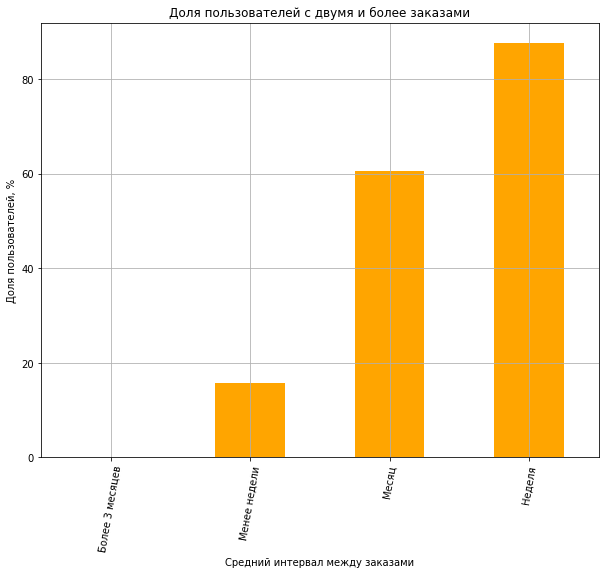

In [284]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

repeated_orders_ratio_two.plot(kind = 'bar',
                   grid = True,
                   legend = False,                                        
                   color = 'orange',
                   rot = 80
)

plt.title('Доля пользователей с двумя и более заказами')
plt.xlabel('Средний интервал между заказами')
plt.ylabel('Доля пользователей, %')

Text(0, 0.5, 'Доля пользователей, %')

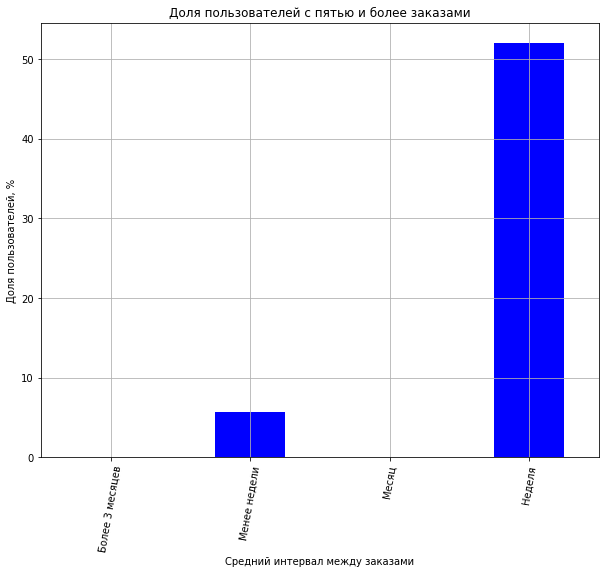

In [285]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

repeated_orders_ratio_five.plot(kind = 'bar',
                   grid = True,
                   legend = False,                                        
                   color = 'blue',
                   rot = 80
)

plt.title('Доля пользователей с пятью и более заказами')
plt.xlabel('Средний интервал между заказами')
plt.ylabel('Доля пользователей, %')

Для анализа были классифицированы интервалы среднего времени между заказами:

* Менее недели;
* Неделя;
* Месяц;
* Более 3 месяцев.

**Доля пользователей с двумя и более заказами.** У большинства пользователей максимальный интервал между заказами(87,57%) - неделя, на втором месте - месяц(60,64%), минимальный - менее недели(15,82%). Отсутствует интервал для категории "более 3 месяцев"(0%). Пользователи с двумя и более заказами не пользуются платформой больше 3 месяцев.

**Доля пользователей с пятью и более заказами.** У большинства пользователей максимальный интервал между заказами(52%) - неделя, на втором месте - менее недели(5,72%), минимальный - месяц(0,0,5%). Отсутствует интервал для категории "более 3 месяцев"(0%). Пользователи с двумя и более заказами не пользуются платформой больше 3 месяцев.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:

- Рассчитаем коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.

In [287]:
# Рассчитываем коэффициент корреляции Пирсона между признаками и total_orders
correlation_matrix = filtered_user_profile.corr()

# Выведем матрицу корреляции
print(correlation_matrix['total_orders'])

total_orders                   1.000000
avg_revenue_rub                0.003153
avg_tickets_count              0.060024
average_time_between_orders    0.075355
is_two                         0.656501
is_five                        0.819935
Name: total_orders, dtype: float64


Полученные значения для столбцов `avg_revenue_rub`, `avg_tickets_count`, `average_time_between_orders` близки к нулю.

- Проверим разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделим сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделим такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.

In [300]:
# Выделим сегменты по количеству заказов
filtered_user_profile.loc[:, 'order_segment'] = pd.cut(
    filtered_user_profile['total_orders'],
    bins=[0, 1, 4, np.inf],
    labels=['1 заказ', 'от 2 до 4 заказов', 'от 5 и выше']
)

# Рассчитаем корреляцию для каждого сегмента отдельно
correlation_by_segment = filtered_user_profile.groupby('order_segment').corr()

# Выведем матрицу корреляции
print('Матрица корреляции для сегмента 1 заказ')
correlation_by_segment.loc[('1 заказ', slice(None)), :].style.background_gradient(cmap='viridis')

Матрица корреляции для сегмента 1 заказ


Матрица корреляции для сегмента '1 заказ': умеренная положительная корреляция наблюдается между столбцами `avg_tickets_count` (среднее количество билетов в заказе) и `avg_revenue_rub` (средняя выручка с билета), то есть связь существует, но она не очень сильная (0,5). Для остальных столбцов значения отсутствуют.

In [301]:
print('Матрица корреляции для сегмента от 5 заказов и выше')
correlation_by_segment.loc[('от 2 до 4 заказов', slice(None)), :].style.background_gradient(cmap='viridis')

Матрица корреляции для сегмента от 2 до 4 заказов


**Матрица корреляции для сегмента 'от 2 до 4 заказов'.**
    
Слабая отрицательная корреляция, указывает на слабую обратную связь:

`total_orders` c `average_time_between_orders` (-0.067);

`average_time_between_orders` c `is_two` (-0.07);

Cлабая отрицательная корреляция, указывает на слабую обратную связь.

Слабая положительная корреляция у столбцов:

`total_orders` с `avg_revenue_rub`(0.006);

`total_orders` с `avg_tickets_count`(0.038);

`avg_revenue_rub` c `average_time_between_orders`(0.053);

`avg_revenue_rub` c `is_two`(0.007);

`avg_tickets_count` c `average_time_between_orders`(0.05);
 
`avg_tickets_count` c `is_two`(0.049);
 
Присутствует небольшая положительная связь, но влияние одной переменной на другую минимально.

Умеренная положительная корреляция для столбцов: `avg_revenue_rub` c `avg_tickets_count`(0.34). Связь существует, но она не очень сильная.

Cильная положительная корреляция у столбцов `total_orders` и `is_two`, то есть связь между переменными выражена ярко. Увеличение одного признака сопровождается значительным увеличением другого.

`is_five` - данные отсутвуют.

In [303]:
# Выведем матрицу корреляции
print('Матрица корреляции для сегмента от 5 заказов и выше')
correlation_by_segment.loc[('от 5 и выше', slice(None)), :].style.background_gradient(cmap='viridis')

Матрица корреляции для сегмента от 5 заказов и выше


**Матрица корреляции для сегмента 'от 5 заказов и выше'.**

Умеренная отрицательная корреляция: 

`total_orders` c `average_time_between_orders`(-0.51);

`average_time_between_orders` c `is_five` (-0.35);

Обратная связь выражена, но не настолько сильно.

Слабая отрицательная корреляция, указывает на слабую обратную связь:

`total_orders` c `avg_revenue_rub` (-0.015);

`avg_revenue_rub` c `is_five` (-0.016);

`avg_revenue_rub` c `is_five` (-0.016);

Слабая отрицательная корреляция, указывает на слабую обратную связь.

Слабая положительная корреляция у столбцов:

`total_orders` c `avg_tickets_count` (0.036);

`avg_revenue_rub` c `average_time_between_orders` (0.11);

`avg_tickets_count` c `average_time_between_orders` (0.00033);

`avg_tickets_count` c `is_five` (0.02);

Присутствует небольшая положительная связь, но влияние одной переменной на другую минимально.

Умеренная положительная корреляция для столбцов: 

`total_orders` c `is_five`(0.47);

`avg_revenue_rub` c `avg_tickets_count`(0.35);

Связь существует, но она не очень сильная.

`is_two` - данные отсутвуют.

- Визуализируем результат корреляции с помощью тепловой карты.

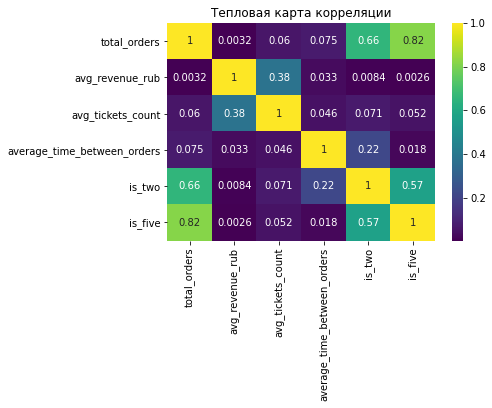

In [306]:
# Построим теплову карту
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Тепловая карта корреляции')
plt.show()

Наиболее связаны с количеством заказов `total_orders` столбцы `average_time_between_orders`(0.08) и `avg_tickets_count`(0.06).

## 5. Общий вывод и рекомендации <a class="anchor" id="chapter5"></a>

* В Pandas были загружены данные датасета `data-analyst-afisha`, в которых представлена информация о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года. Датасет содержал 14 столбцов и 290610 строк. Данные содержат информацию о заказах билетов, событиях, городах и регионах событий, площадках мероприятий, о курсе тенге к российскому рублю за 2024 год (дополнительный датасет `final_tickets_tenge_df.csv`).


* При первичном знакомстве с данными и их предобработке выявили, что в одном столбце `days_since_prev` ~ 8%, образованы по причине отсутствия покупок у пользователей - оставлены без изменений, чтобы избежать искажения данных. По столбцам `revenue_rub` с выручкой и `tickets_count` с количеством билетов в заказе были отфильтрованы данные до 99-го перцентиля, исключив выбросы и сохранив репрезентативность. Явных дубликатов нет, не явные - 18.33% (удалены). Созданы новые столбцы: revenue_rub — выручка с заказа к единой валюте (российский рубль). Удалено 19.20% данных (выбросы). Итоговый объем - 234814 строк.


* Анализ данных показал, что по популярности мероприятий лидируют — концерты, другое и театры. Среди регионов явные лидеры по числу заказов и выручке с продажи билетов: Каменевский регион, Североярская область. Среди партнером явные лидеры по числу заказов: "Билеты без проблем" (максимум заказов), "Мой билет", "Лови билет!", "Билеты в руки", "Облачко".  В среднем, количество билетов в заказе - 2-3 шт. Максимальный интервал времени между заказами - неделя. Средняя выручка с билетов в среднем варьируется от 250 до 650 руб.


* Наибольшее количестко первых заказов делалось с мобильных устройств. Мобильное приложение стимулирует частые покупки — возможно, за счёт удобства или push-уведомлений. Вероятно, мобильные заказы могут быть более спонтанными, а десктопные — запланированными (например, крупные покупки). Мобильные пользователи заказывают реже, но в большем объёме.


* Наиболее связаны с количеством заказов total_orders столбцы average_time_between_orders(0.08) и avg_tickets_count(0.06).

**Рекомендации:**

* Продвигать мероприятия, у которых минимальный спрос на платформе (стендап и ёлки);
* Для десктопных пользователей — предлагать подписки/напоминания о повторных заказах. Для мобильных — предлагать скидки на повторные заказы, акции на групповые покупки или премиум-услуги; 
* Важно работать с партнёрами и регионами-лидерами.

## 6. Финализация проекта и публикация в Git<a class="anchor" id="chapter6"></a>

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Ссылку на проект:**
https://github.com/PutilEl/Yandex_afisha_user_behavior